In [1]:
suppressPackageStartupMessages(library(dplyr)) 
library(ggplot2)
library(pheatmap)
library(repr)
library(RColorBrewer)
suppressPackageStartupMessages(library(ggalluvial))

library(Seurat)

source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")

Warning message:
“package ‘pheatmap’ was built under R version 4.3.2”
Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Warning message:
“package ‘dichromat’ was built under R version 4.3.2”
Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal




In [2]:
suppressPackageStartupMessages(library("msigdbr"))
suppressPackageStartupMessages(library("fgsea"))

suppressPackageStartupMessages(library(GenomicRanges))
suppressPackageStartupMessages(library(enrichR))
dbs <- c("GO_Biological_Process_2021")

suppressPackageStartupMessages(library(clusterProfiler))
suppressPackageStartupMessages(library(org.Hs.eg.db))

In [3]:
### annotate peaks
sum_detailed_anno <- function(df){
    t1 <- table(df$Detailed.Annotation) %>% as.data.frame %>%
    mutate(Var1 = gsub("^([^\\(]+).*", "\\1", Var1)) %>%
    group_by(Var1) %>% summarise(Freq = sum(Freq))

    t1a1 <- t1[grep("\\|", t1$Var1, invert = T), ] %>%
    mutate(Var1 = gsub("^(CpG)-.*$", "\\1", Var1)) %>%
    group_by(Var1) %>% summarise(Freq = sum(Freq)) %>% setNames(c("Var1", "Freq"))

    t1a2 <- t1[grep("\\|", t1$Var1), ] %>% 
    mutate(Var1 = gsub("^([^|]+)\\|([^|]+)\\|([^|]+)$", "\\2", Var1)) %>%
    mutate(Var1 = gsub("\\?", "", Var1)) %>%
    mutate(simple = ifelse(Var1 %in% c("LINE", "LTR", "SINE", "Simple_repeat"), Var1, "Other repeats")) %>%
    group_by(simple) %>% summarise(Freq = sum(Freq)) %>% setNames(c("Var1", "Freq"))

    anno <- rbind(t1a1, t1a2)
    return(anno)
}

In [12]:
### set cell tree
corder <- c('vCM','aCM','Epicardial','SM','Pericyte','Neuronal','Fibroblast',
            'Adipocyte','Endothelial','Endocardial','Myeloid','Lymphoid')

celltype_colors <- c(
    vCM = "#b94656",
    aCM = "#b95c38",
    Fibroblast = "#c0a13b",
    SM = "#71893b",
    Pericyte = "#6dbc5f",
    Epicardial = "#45c097",
    Endocardial = "#628ed6",
    Endothelial = "#6a70d7",
    Neuronal = "#5a3687",
    Myeloid = "#c074cc",
    Lymphoid = "#d16bad",
    Adipocyte = "#aa3d71"
)

cols1 <- c('#1F78B4', '#FB9A99'); names(cols1) <- c("M", "F")
cols2 <- c('#B2DF8A', '#FF7F00', '#CAB2D6'); names(cols2) <- c("CONTROL", "Ischemic", "Non-ischemic")
cols3 <- c('#B15928', '#FDBF6F'); names(cols3) <- c("TRUE", "FALSE")
cols4 <- c("#006934", "#2EA7E0", "#956134", "#036EB8"); names(cols4) <- c("Hi-C", "H3K27ac", "H3K27me3","ATAC")
cols5 <- c("#4f652f", "#d44f3a", "#5bac96", "#e6b8b3"); names(cols5) <- c("LV", "LA", "RV","RA")
cols <- c("#cd5c5c", "#c0c0c0", "#008000", "#ffc800", '#66cdaa')
names(cols) <- c("E1", "E2", "E3", "E4", "E5")

cols0 <- c('3\' UTR ' = "#6F4066",
           '5\' UTR ' = "#B78EA6",
           'CpG' = "#71818D",
           'Intergenic' = "#326680",
           'TTS ' = "#B0BEC5",
           'exon ' = "#527172",
           'intron ' = "#495347",
           'non-coding ' = "#73A085",
           'promoter-TSS ' = "#D0C185",
           'LINE' = "#ECBF6D",
           'LTR' = "#C56D48",
           'Other repeats' = "#C0A08D",
           'SINE' = "#B05857",
           'Simple_repeat' = "#701B28")

In [3]:
wdir <- "/projects//ps-renlab2/y2xie/projects/77.LC/81.FNIH_DPT_IGM_240827/"

## Overlap of ABC links with DEG and DAR

In [ ]:
## import chromatin states, CPM and DAR results
chmm <- list()
for (f in list.files("chromhmm/disease_annotate/", pattern = "^Heart_UnionPeak.*")){
    fname = gsub("_annotate.bed", "", f)
    chmm[[f]] <- read.table(paste0("chromhmm/disease_annotate/", f)) %>% 
    mutate(range = paste0(V1, ":", V2, "-", V3)) %>%
    dplyr::select(c(range, V4)) %>% 
    group_by(range) %>%
    slice_sample(n = 1) %>%
    ungroup() %>%
    tibble::column_to_rownames("range") %>% setNames(fname)
}
commonf <- Reduce(intersect, lapply(chmm, rownames))
for (f in names(chmm)){
    chmm[[f]] <- chmm[[f]][commonf, , drop = F]
}
chmm <- Reduce(cbind, chmm[-1], chmm[[1]]) ### dont use do.call for cbind

In [ ]:
atac <- read.table(paste0(wdir, "/reference/ATAC_celltype_HF.cpm.txt"))
k27ac <- read.csv(paste0(wdir, "FNIH_Heart_signal/FNIH_Heart_pool.H3K27ac.disease.HeartUnionPeak.cpm.csv"), row.names = 1)
k27me3 <- read.csv(paste0(wdir, "FNIH_Heart_signal/FNIH_Heart_pool.H3K27me3.disease.HeartUnionPeak.cpm.csv"), row.names = 1)
colnames(atac) <- gsub("NON.HF", "CONTROL", colnames(atac))

rpkm <- read.table(paste0(wdir, "integration/FNIH_Heart_pool.int.disease.rpkm.txt"))

In [240]:
atacder <- read.table(paste0(wdir, "reference/Multiome_Downstream/CHAMBER/4chambers_DESEQ2_ATAC.dds.res"), header = T) %>%
setNames(c("celltype", "contrast", "range", "log2FoldChange", "stat", "pvalue", "padj"))

geneder <- read.table(paste0(wdir, "../reference/Multiome_Downstream/CHAMBER/4chambers_DESEQ2_RNA.dds.res"), header = T) %>%
setNames(c("celltype", "contrast", "gene", "log2FoldChange", "stat", "pvalue", "padj"))

In [192]:
atacde <- read.table("../reference/Multiome_Downstream/CHAMBER/4chambers_DESEQ2_ATAC.dds.res", header = T) %>%
filter(ATAC_Padj < 0.05) %>%
setNames(c("celltype", "contrast", "range", "log2FoldChange", "stat", "pvalue", "padj"))

atacde %>% filter(log2FoldChange > 0) %>% dplyr::select(celltype) %>% table
atacde %>% filter(log2FoldChange < 0) %>% dplyr::select(celltype) %>% table

celltype
        aCM Endocardial Endothelial  Fibroblast     Myeloid    Neuronal 
       2561         101        1814        8566        2161          72 
   Pericyte          SM         vCM 
        718          37       13163 

celltype
        aCM Endocardial Endothelial  Fibroblast    Lymphoid     Myeloid 
       1812          25         840        9726           1        1960 
   Neuronal    Pericyte          SM         vCM 
         37         732          25       15394 

In [349]:
### Compare targeting genes for diff ATAC peaks
abc <- abc %>% mutate(range = sub(":", "-", range))

atacde$celltype %>% table

merge(atacde, abc, by = "range") %>%
filter(celltype == CellType) %>%
dplyr::select(celltype) %>% table

merge(atacde, abc, by = "range") %>%
filter(celltype == CellType) %>%
filter(abs(log2FoldChange) >= 0.5) %>%
dplyr::select(celltype) %>% table

.
        aCM Endocardial Endothelial  Fibroblast    Lymphoid     Myeloid 
       3775         103        2294       16709           1        3446 
   Neuronal    Pericyte          SM         vCM 
         91        1180          51       22046 

celltype
        aCM Endocardial Endothelial  Fibroblast     Myeloid    Neuronal 
        224          72         858        1040         985          69 
   Pericyte          SM         vCM 
        551          26        1505 

celltype
        aCM Endocardial Endothelial  Fibroblast     Myeloid    Neuronal 
        189          72         635         810         871          69 
   Pericyte          SM         vCM 
        410          26         440 

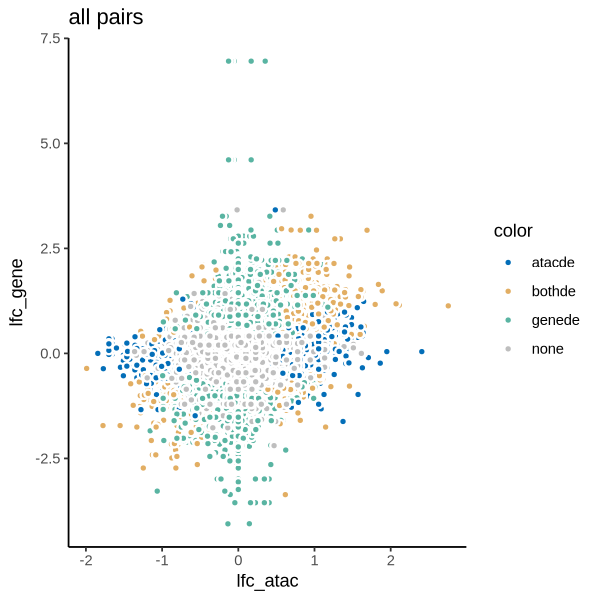

In [777]:
### Differential links: overlap with either differential peaks or genes
flist <- list()
for (f in unique(abc$CellType)){
    qqq <- abc %>% filter(CellType == f)
    qregion <- atacde %>% filter(celltype == f) %>% dplyr::select(range) %>% unlist
    qgene <- genede %>% filter(celltype == f) %>% dplyr::select(gene) %>% unlist

    qgeneder <- geneder %>% filter(celltype == f)
    qatacder <- atacder %>% filter(celltype == f)
    qqq$lfc_gene <- qgeneder[match(qqq$TargetGene, qgeneder$gene),]$log2FoldChange
    qqq$lfc_atac <- qatacder[match(qqq$range, qatacder$range),]$log2FoldChange
    qqq$lfc_gene[is.na(qqq$lfc_gene)] <- 0
    qqq$lfc_atac[is.na(qqq$lfc_atac)] <- 0
    
    flist[[f]] <- qqq %>%
    mutate(color = ifelse(TargetGene %in% qgene, "genede", "none")) %>%
    mutate(color = ifelse(range %in% qregion, "atacde", color)) %>%
    mutate(color = ifelse((range %in% qregion) & (TargetGene %in% qgene), "bothde", color))
}

do.call(rbind, flist) %>%
filter(CellType %in% korder) %>%
ggplot(aes(x = lfc_atac, y = lfc_gene, fill = color)) + 
geom_point(color = "white", stroke = 1, shape = 21) + 
theme_classic() + ggtitle("all pairs") + 
scale_fill_manual(values = c("#036EB8", "#E2AE63", "#59b4a2", "grey"))

t1 <- do.call(rbind, flist) %>%
filter(CellType %in% korder, color != "none") %>%
ggplot(aes(x = lfc_atac, y = lfc_gene, fill = color)) + 
geom_point(color = "white", stroke = 1, shape = 21) + 
theme_classic() + ggtitle("all pairs") + 
scale_fill_manual(values = c("#036EB8", "#E2AE63", "#59b4a2", "grey"))

ggsave(t1, filename = "plot/FIG_abc_ovlp_DEgenes_DApeaks.pdf", dpi = 300, height = 5.5, width = 6)
write.table(t1$data, "plot/FIG_abc_ovlp_DEgenes_DApeaks.txt", sep = "\t", quote = F)

In [780]:
cor.test(t1$data$lfc_gene, t1$data$lfc_atac)


	Pearson's product-moment correlation

data:  t1$data$lfc_gene and t1$data$lfc_atac
t = 41.85, df = 13741, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3213202 0.3509791
sample estimates:
     cor 
0.336233 


### diff ABC links and Hi-C support

In [804]:
system("mkdir -p ../../87.FNIH_DHC_IGM_240925/05.R/APA/diff_abc")
tmp <- do.call(rbind, flist) %>%
filter(CellType %in% korder, color != "none") 

for (f in korder){
    utmp <- tmp %>% filter(CellType == f) %>% 
    filter(lfc_atac > 0, lfc_atac * lfc_gene > 0) %>%
    dplyr::select(chr, start.x, end.x, chrom.x, start.y, end.y)
    dtmp <- tmp %>% filter(CellType == f) %>% 
    filter(lfc_atac < 0, lfc_atac * lfc_gene > 0) %>%
    dplyr::select(chr, start.x, end.x, chrom.x, start.y, end.y)
    system(paste0("mkdir -p ../../87.FNIH_DHC_IGM_240925/05.R/APA/diff_abc/", f, "_up"))
    write.table(utmp, paste0("../../87.FNIH_DHC_IGM_240925/05.R/APA/diff_abc/", f, "_up/peaks.bedpe"),
                sep = "\t", quote = F, row.names = F, col.names = F)
    system(paste0("mkdir -p ../../87.FNIH_DHC_IGM_240925/05.R/APA/diff_abc/", f, "_down"))
    write.table(dtmp, paste0("../../87.FNIH_DHC_IGM_240925/05.R/APA/diff_abc/", f, "_down/peaks.bedpe"),
                sep = "\t", quote = F, row.names = F, col.names = F)
}

Using id as id variables

Using id as id variables

Using id as id variables

Using id as id variables



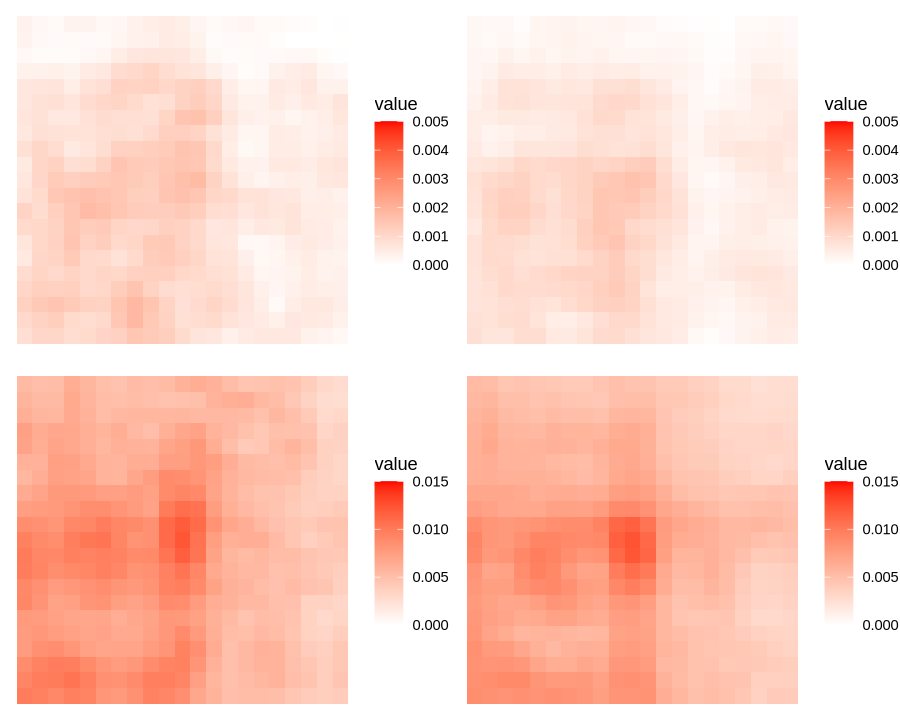

In [836]:
### Read and plot APA to see whether signal changes
### do it for vCM and Myeloid
plist <- list()
ct <- 'Myeloid'
for (file in list.files("../../87.FNIH_DHC_IGM_240925/05.R/APA/diff_abc/", pattern = paste0("^", ct))){
    for (ffile in list.files(paste0("../../87.FNIH_DHC_IGM_240925/05.R/APA/diff_abc/", file), pattern = paste0("^", ct))){
        tmp <- read.csv(paste0("../../87.FNIH_DHC_IGM_240925/05.R/APA/diff_abc/", file, "/", ffile, "/10000/gw/APA.txt"), header = F)
        tmp$V1 <- gsub("\\[", "", tmp$V1) %>% as.numeric
        tmp$V21 <- gsub("\\]", "", tmp$V21) %>% as.numeric
        plist[[paste0(file, ":", ffile)]] <- tmp
    }
}

pplist <- list()
for (i in 1:length(plist)){
    name <- stringr::str_split_fixed(names(plist)[i], pattern = ":", n = 2)
    pplist[[i]] <- plist[[i]] %>% mutate(id = colnames(.)) %>%
    reshape2::melt() %>% 
    mutate(id = as.integer(gsub("V", "", id))) %>% arrange(id) %>% 
    mutate(variable = as.integer(gsub("V", "", variable))) %>% arrange(variable) %>% 
    ggplot(aes(x = variable, y = -id, fill = value)) + 
    geom_tile() + NoLegend() + theme_void() + 
    xlab(name[1]) + ylab(name[2]) #+ scale_fill_gradientn(colours = c("white", "red"), limits = c(0, 0.015))
}

options(repr.plot.width = 7.5, repr.plot.height = 6)
t1 <- cowplot::plot_grid(plotlist = lapply(pplist[1:2], function(x) x + scale_fill_gradientn(colours = c("white", "red"), limits = c(0, 0.005))), 
                   ncol = 2)

t2 <- cowplot::plot_grid(plotlist = lapply(pplist[3:4], function(x) x + scale_fill_gradientn(colours = c("white", "red"), limits = c(0, 0.015))), 
                   ncol = 2)

fig1 <- cowplot::plot_grid(t1, t2, nrow = 2)
                         
fig1

## Define HF-associated TF from SCENIC+

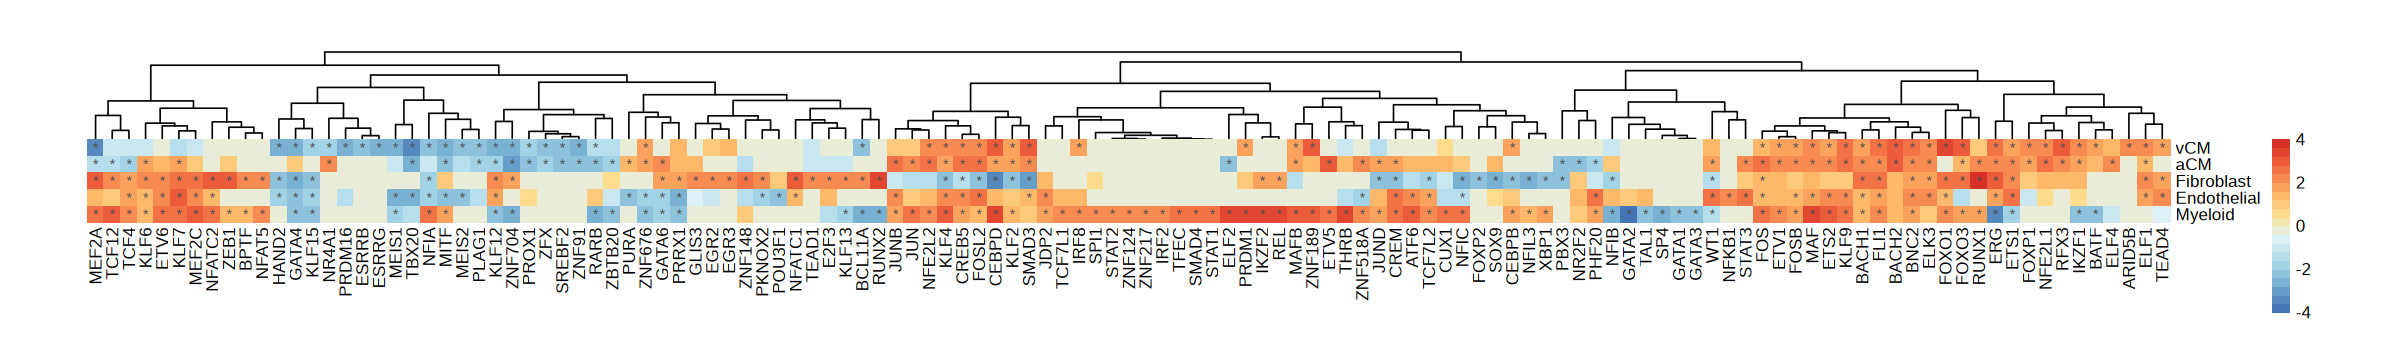

In [1067]:
### fGSEA of SCENIC+ peaks in HF versus CONTROL
fgsea_results <- list()
for (f in list.files("GRN/scenicplus/")){
    ct <- grep(f, corder, value = T)[1]
    elist <- read.csv(paste0("GRN/scenicplus/", f, "/edges_R2G.csv")) %>% filter(is_extended == "False")
    rpeak <- read.table(paste0("../reference/FNIH_peaks/unified_peaks/", ct, "_UnifiedFiltVariable.bed")) %>%
    mutate(range = paste0(V1, ":", V2, "-", V3))
    elist <- elist %>% filter(Region %in% rpeak$range) ### retain peaks within that celltype
    tfr <- stringr::str_split_fixed(elist$Consensus_name, pattern = "_", n = 3)[,1] %>% unique
    grnlist <- list()
    for (tf in tfr){
        grnlist[[tf]] <- elist %>% filter(Consensus_name == paste0(tf, "_+_+")) %>% dplyr::select(Region) %>% unlist %>% unique
    }
    ranked_genes <- read.table("../reference/Multiome_Downstream/CHAMBER/4chambers_DESEQ2_ATAC.dds.res", header = T) %>%
    setNames(c("celltype", "contrast", "range", "log2FoldChange", "stat", "pvalue", "padj")) %>% 
    filter(celltype == ct) %>% arrange(desc(stat)) %>%
    mutate(range = sub("-", ":", range)) %>%
    dplyr::select(range, stat) %>% tibble::deframe()
    
    fgsea_results[[ct]] <- fgsea(pathways = grnlist, stats = ranked_genes, nperm = 10000)
    fgsea_results[[ct]]$celltype <- ct
}

qpathway <- do.call(rbind, fgsea_results) %>%
group_by(pathway) %>%
filter(min(padj) < 0.05) %>%
ungroup() %>%
dplyr::select(pathway) %>% unlist %>% unique

rmat <- do.call(rbind, fgsea_results) %>%
filter(pathway %in% qpathway) %>%
mutate(value = NES) %>%
reshape2::dcast(celltype ~ pathway, value.var = "value") %>%
tibble::column_to_rownames("celltype") 

rmat <- rmat[c('vCM','aCM','Fibroblast','Endothelial','Myeloid'),] %>% t
rmat[is.na(rmat)] <- 0

lmat <- do.call(rbind, fgsea_results) %>%
filter(padj < 0.05) %>%
mutate(value = padj) %>%
reshape2::dcast(celltype ~ pathway, value.var = "value") %>%
tibble::column_to_rownames("celltype") 

lmat <- lmat[c('vCM','aCM','Fibroblast','Endothelial','Myeloid'),]
lmat[is.na(lmat)] <- 1
lmat <- ifelse(lmat < 0.05, "*", "")

options(repr.plot.width = 20, repr.plot.height = 3)
rmat <- rmat[apply(rmat, 1, function(x) max(abs(x)) >= 2),] %>% t
                   
t1 <- rmat %>%
pheatmap(cluster_rows = F, border_color = NA, angle_col = 90, cellwidth = 10, cellheight = 10,
         display_numbers = lmat[,colnames(rmat)], breaks = seq(-4,4,0.4),
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdYlBu"))(20)))

In [1068]:
### check GRN associated peaks / GEX
atacder <- read.table("../reference/Multiome_Downstream/CHAMBER/4chambers_DESEQ2_ATAC.dds.res", header = T) %>%
setNames(c("celltype", "contrast", "range", "log2FoldChange", "stat", "pvalue", "padj"))

geneder <- read.table("../reference/Multiome_Downstream/CHAMBER/4chambers_DESEQ2_RNA.dds.res", header = T) %>%
setNames(c("celltype", "contrast", "gene", "log2FoldChange", "stat", "pvalue", "padj"))

grnglist <- grnplist <- list()
for (f in list.files("GRN/scenicplus/")){
    ct <- grep(f, corder, value = T)[1]
    elist <- read.csv(paste0("GRN/scenicplus/", f, "/edges_R2G.csv")) %>% filter(is_extended == "False")
    rpeak <- read.table(paste0("../reference/FNIH_peaks/unified_peaks/", ct, "_UnifiedFiltVariable.bed")) %>%
    mutate(range = paste0(V1, ":", V2, "-", V3))
    elist <- elist %>% filter(Region %in% rpeak$range) ### retain peaks within that celltype
    tfr <- stringr::str_split_fixed(elist$Consensus_name, pattern = "_", n = 3)[,1] %>% unique
    
    glist <- plist <- list()
    for (tf in tfr){
        qregion <- elist %>% filter(Consensus_name == paste0(tf, "_+_+")) %>% dplyr::select(Region) %>% unlist %>% unique
        qgene <- elist %>% filter(Consensus_name == paste0(tf, "_+_+")) %>% dplyr::select(Gene) %>% unlist %>% unique
        plist[[tf]] <- atacder %>% filter(celltype == ct) %>% mutate(range = sub("-", ":", range)) %>%
        filter(range %in% qregion) %>% dplyr::select(log2FoldChange) %>% 
        summarise(medianl = median(log2FoldChange), meanl = mean(log2FoldChange))
        glist[[tf]] <- geneder %>% filter(celltype == ct) %>% 
        filter(gene %in% qgene) %>% dplyr::select(log2FoldChange) %>% 
        summarise(medianl = median(log2FoldChange), meanl = mean(log2FoldChange))
    }
    grnglist[[ct]] <- do.call(rbind, plist) %>% mutate(celltype = ct)
    grnplist[[ct]] <- do.call(rbind, glist) %>% mutate(celltype = ct)
}

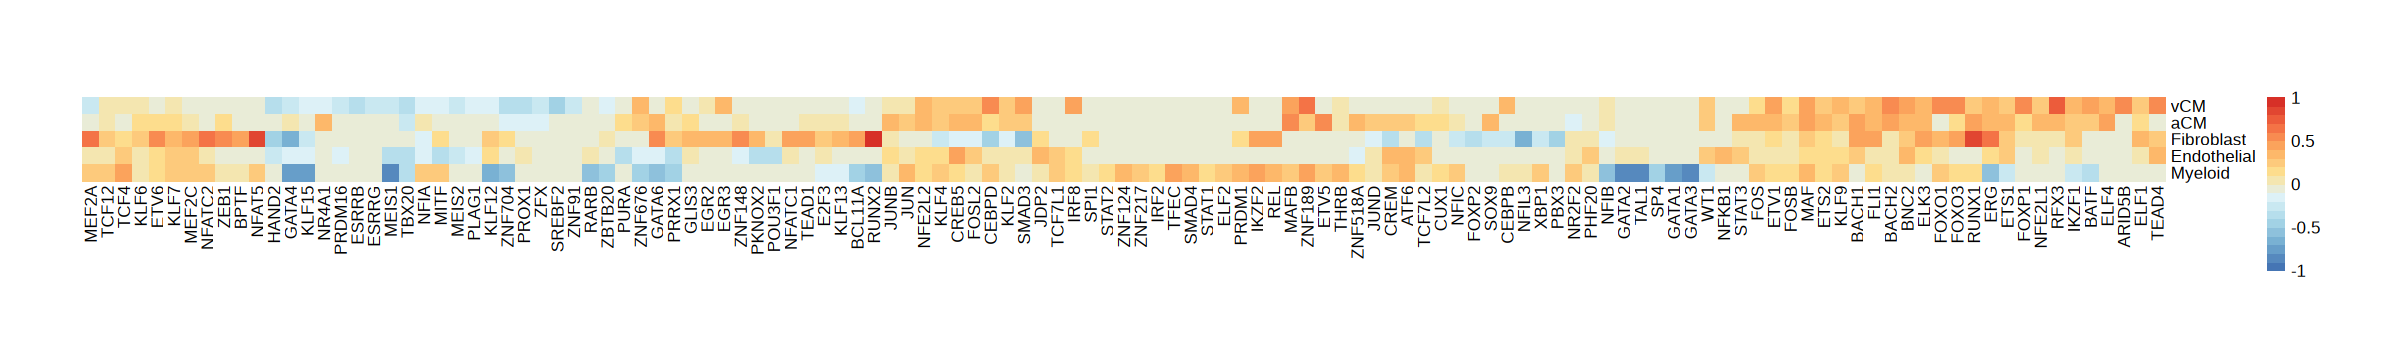

In [1071]:
### GRN targeting genes FC
tmat <- do.call(rbind, lapply(grnglist, function(x) x %>% tibble::rownames_to_column("pathway"))) %>%
mutate(value = meanl) %>%
reshape2::dcast(celltype ~ pathway, value.var = "value") %>%
tibble::column_to_rownames("celltype") 

tmat[is.na(tmat)] <- 0

options(repr.plot.width = 20, repr.plot.height = 3)
t2 <- tmat[rownames(rmat), t1$tree_col$labels[t1$tree_col$order]] %>%
pheatmap(cluster_rows = F, cluster_cols = F, breaks = seq(-1,1,0.1),
         border_color = NA, angle_col = 90, cellwidth = 10, cellheight = 10,
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdYlBu"))(20)))

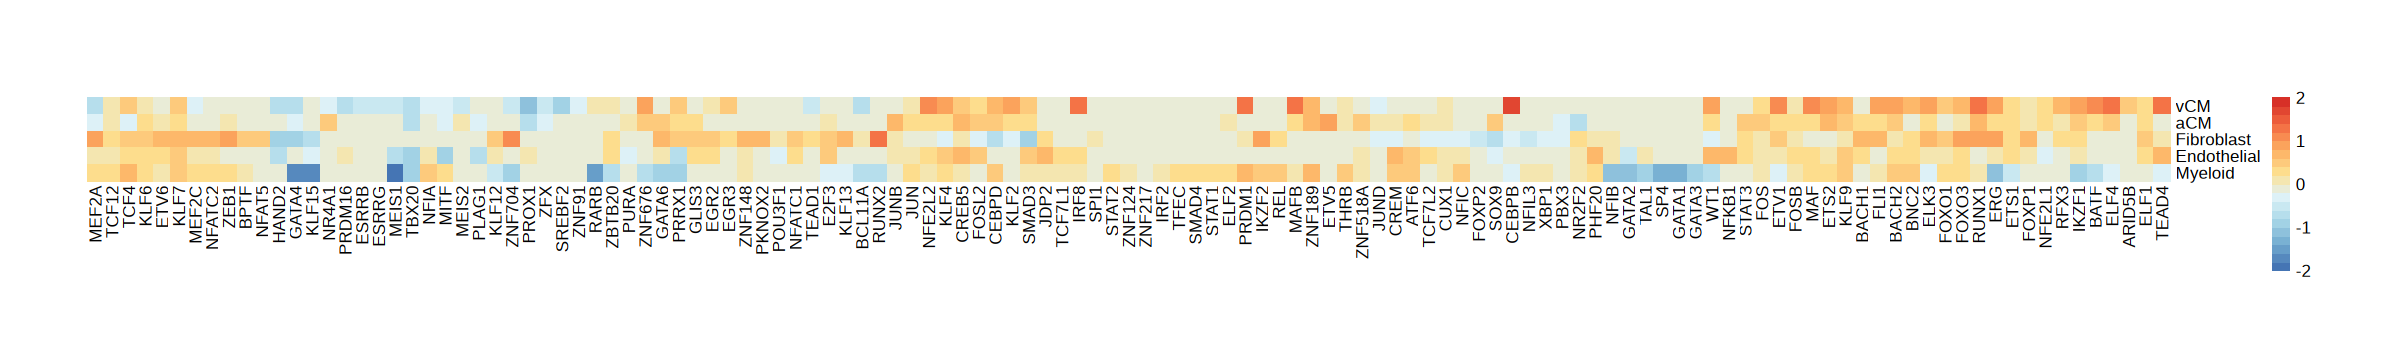

In [1072]:
### GRN targeting regions FC
tmat <- do.call(rbind, lapply(grnplist, function(x) x %>% tibble::rownames_to_column("pathway"))) %>%
mutate(value = meanl) %>%
reshape2::dcast(celltype ~ pathway, value.var = "value") %>%
tibble::column_to_rownames("celltype") 

tmat[is.na(tmat)] <- 0

options(repr.plot.width = 20, repr.plot.height = 3)
t3 <- tmat[rownames(rmat), t1$tree_col$labels[t1$tree_col$order]] %>%
pheatmap(cluster_rows = F, cluster_cols = F, breaks = seq(-2,2,0.2),
         border_color = NA, angle_col = 90, cellwidth = 10, cellheight = 10,
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdYlBu"))(20)))

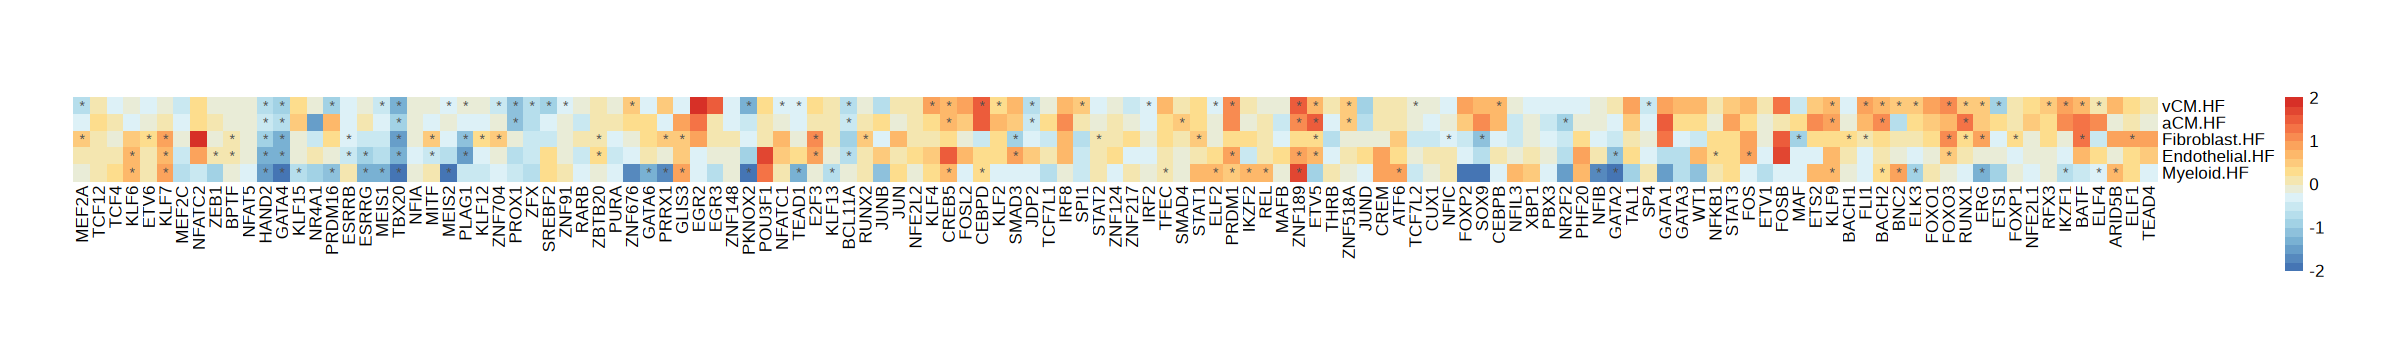

In [1073]:
### check GRN associated TF expression changes
tflist <- list()
for (f in t1$tree_col$labels[t1$tree_col$order]){
    tflist[[f]] <- geneder %>% filter(gene == f) %>% filter(celltype %in% rownames(rmat)) %>% 
    dplyr::select(celltype, gene, log2FoldChange, padj)
}

m1 <- log2(rpkm[t1$tree_col$labels[t1$tree_col$order], paste0(rownames(rmat), ".HF")]/rpkm[t1$tree_col$labels[t1$tree_col$order], paste0(rownames(rmat), ".CONTROL")]) %>%
t %>% as.data.frame

lmat <- do.call(rbind, tflist) %>%
mutate(value = padj) %>%
reshape2::dcast(celltype ~ gene, value.var = "value") %>%
tibble::column_to_rownames("celltype") 

lmat[,setdiff(colnames(m1), colnames(lmat))] <- 1
lmat <- lmat[rownames(rmat),t1$tree_col$labels[t1$tree_col$order]]
lmat[is.na(lmat)] <- 1
lmat <- ifelse(lmat < 0.05, "*", "")

t4 <- m1 %>%
pheatmap(cluster_rows = F, cluster_cols = F, display_numbers = lmat, breaks = seq(-2,2,0.2),
         border_color = NA, angle_col = 90, cellwidth = 10, cellheight = 10,
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdYlBu"))(20)))

Using gene as id variables

Using gene as id variables

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


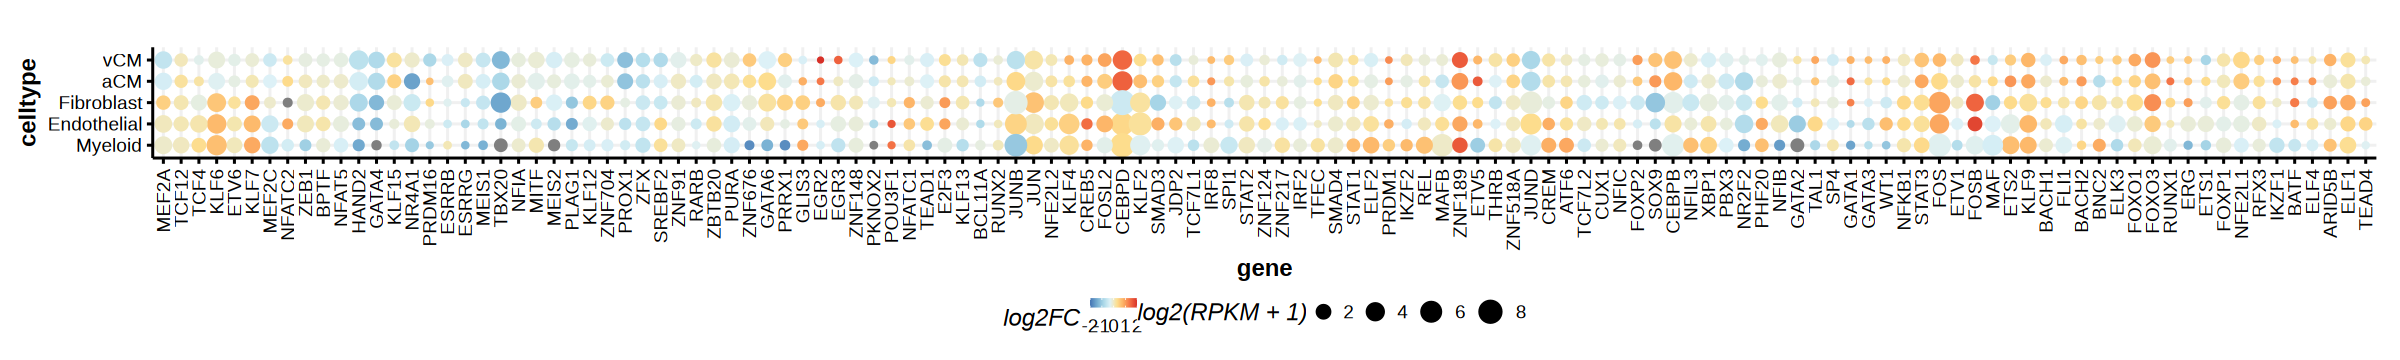

In [1074]:
m1 <- log2(rpkm[t1$tree_col$labels[t1$tree_col$order], paste0(rownames(rmat), ".HF")]/rpkm[t1$tree_col$labels[t1$tree_col$order], paste0(rownames(rmat), ".CONTROL")]) %>%
as.data.frame %>% tibble::rownames_to_column("gene") %>%
reshape2::melt() %>% mutate(variable = gsub(".HF", "", variable))

m2 <- rpkm[t1$tree_col$labels[t1$tree_col$order], paste0(rownames(rmat), ".CONTROL")] %>%
tibble::rownames_to_column("gene") %>%
reshape2::melt() %>% mutate(variable = gsub(".CONTROL", "", variable))

t5 <- merge(m1, m2, by = c("gene", "variable")) %>%
setNames(c("gene", "celltype", "log2FC", "RPKM")) %>%
mutate(celltype = factor(celltype, levels = rev(rownames(rmat)))) %>%
mutate(gene = factor(gene, levels = t1$tree_col$labels[t1$tree_col$order])) %>%
ggplot(aes(x = gene, y = celltype, size = log2(RPKM+1), color = log2FC)) + 
geom_point() + 
theme_Publication() + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
scale_color_gradientn(colors = rev(colorRampPalette(brewer.pal(n = 8, name = "RdYlBu"))(20)), 
                     limits = c(-2, 2))

t5
ggsave(t5, filename = "plot/FIG_SCENIC_HF_vs_CONTROL_fgsea_absNES2_TF_FC_dotmap.pdf", dpi = 300, height = 3.5, width = 21)
write.table(t5$data, "plot/FIG_SCENIC_HF_vs_CONTROL_fgsea_absNES2_TF_FC_dotmap.txt", 
            sep = "\t", quote = F, row.names = T, col.names = T)

In [1075]:
### Which TF show diff expression and also with TF/Control enriched targets?
f1 <- do.call(rbind, fgsea_results) %>%
filter(padj < 0.05) %>%
dplyr::select(c(pathway, NES, celltype)) %>%
setNames(c("gene", "NES", "celltype"))

f2 <- do.call(rbind, tflist) %>%
filter(padj < 0.05) %>%
dplyr::select(c(gene, log2FoldChange, celltype))

merge(f1, f2, by = c("gene", "celltype")) %>% head
merge(f1, f2, by = c("gene", "celltype")) %>% dim

gene,celltype,NES,log2FoldChange
<chr>,<chr>,<dbl>,<dbl>
ATF6,Myeloid,2.814263,0.8893278
BACH1,Fibroblast,2.788580,0.4076840
BACH2,aCM,3.143135,1.3221522
BACH2,vCM,3.134032,1.0826266
BATF,vCM,1.608295,1.5083377
BCL11A,vCM,-2.033817,-0.8797314


[1] 95  4

In [1077]:
upGRN <- merge(f1, f2, by = c("gene", "celltype")) %>%
mutate(pathway = ifelse(NES > 0, "up", "down")) %>%
mutate(TF = ifelse(log2FoldChange > 0, "up", "down")) %>%
filter(pathway == "up", TF == "up")

downGRN <- merge(f1, f2, by = c("gene", "celltype")) %>%
mutate(pathway = ifelse(NES > 0, "up", "down")) %>%
mutate(TF = ifelse(log2FoldChange > 0, "up", "down")) %>%
filter(pathway == "down", TF == "down")

table(upGRN$celltype)
table(downGRN$celltype)


        aCM Endothelial  Fibroblast     Myeloid         vCM 
          6           5          16          13          18 


        aCM Endothelial  Fibroblast     Myeloid         vCM 
          3           4           5          10          14 

In [1262]:
### classify: cell type specific / common / bi-directional TFs
tfclass <- rbind(downGRN, upGRN)[,c("gene", "celltype")] %>% 
distinct %>% 
group_by(gene) %>% 
summarise(freq = length(celltype)) %>%
mutate(class = ifelse(freq > 1, "shared", "specific")) 

dual <- intersect(unique(upGRN$gene), unique(downGRN$gene))

In [1264]:
table(tfclass$class)
dual


  shared specific 
      23       41 

[1] "ERG"    "IKZF1"  "MEF2A"  "PRRX1"  "SMAD3"  "ZNF704"

In [1078]:
elist <- list()
for (f in list.files("GRN/scenicplus/")){
    ct <- grep(f, corder, value = T)[1]
    tmp <- read.csv(paste0("GRN/scenicplus/", f, "/edges_R2G.csv")) %>% 
    filter(is_extended == "False") %>% mutate(celltype = ct)
    rpeak <- read.table(paste0("../reference/FNIH_peaks/unified_peaks/", ct, "_UnifiedFiltVariable.bed")) %>%
    mutate(range = paste0(V1, ":", V2, "-", V3))
    elist[[ct]] <- tmp %>% filter(Region %in% rpeak$range) ### retain peaks within that celltype
}
elist <- do.call(rbind, elist)

tmp <- rbind(upGRN, downGRN)
tmp$Consensus_name <- paste0(tmp$gene, "_+_+")
tmp <- merge(elist, tmp, by = c("Consensus_name", "celltype")) %>%
dplyr::select(-X, -is_extended) 

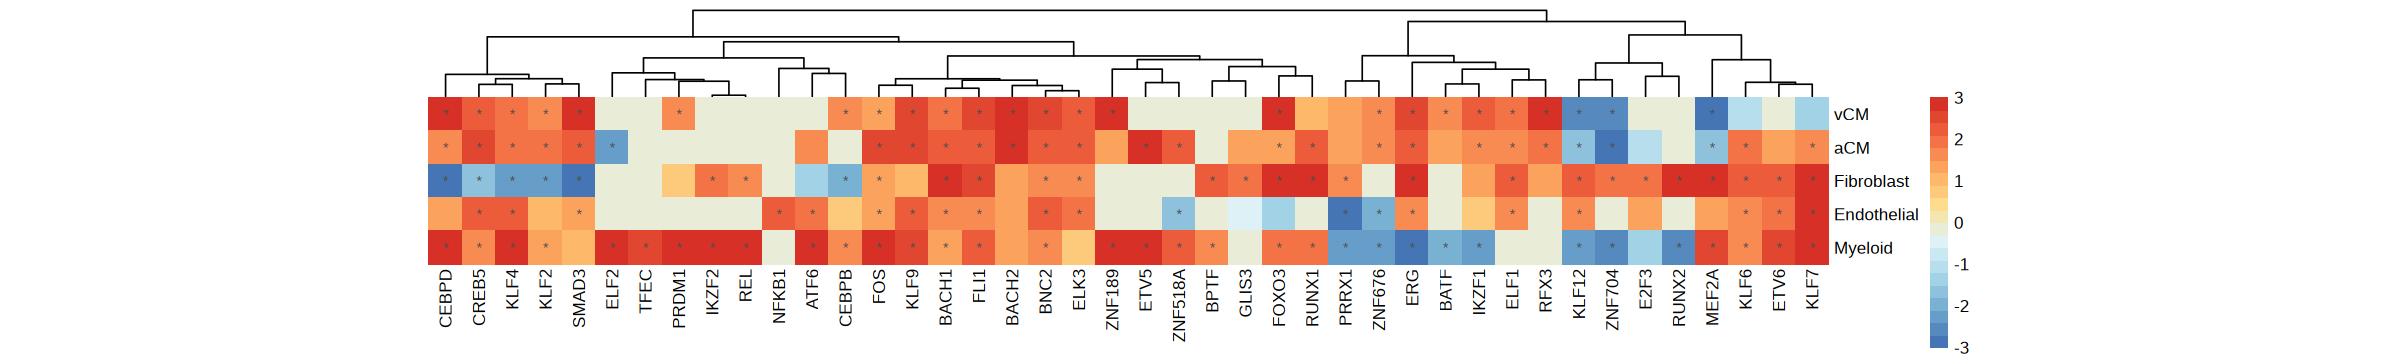

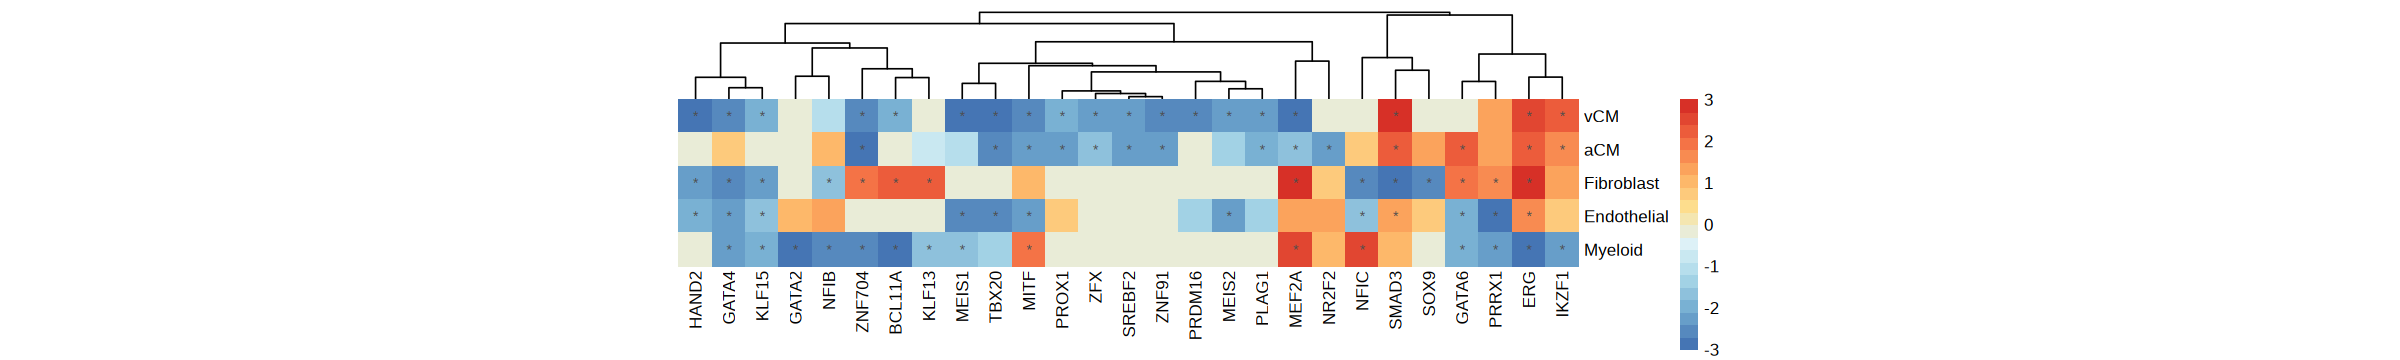

In [1261]:
### only display GRNs with consistent, significant fold changes
options(repr.plot.width = 20, repr.plot.height = 3)

### add significance
lmat <- do.call(rbind, fgsea_results) %>%
filter(padj < 0.05) %>%
mutate(value = padj) %>%
reshape2::dcast(celltype ~ pathway, value.var = "value") %>%
tibble::column_to_rownames("celltype") 

lmat <- lmat[c('vCM','aCM','Fibroblast','Endothelial','Myeloid'),]
lmat[is.na(lmat)] <- 1
lmat <- ifelse(lmat < 0.05, "*", "")

t1 <- rmat[,unique(upGRN$gene)] %>% 
pheatmap(cluster_rows = F, cluster_cols = T, display_numbers = lmat[,unique(upGRN$gene)], breaks = seq(-3,3,0.3),
         border_color = NA, angle_col = 90, cellwidth = 20, cellheight = 20,
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdYlBu"))(20)))

options(repr.plot.width = 20, repr.plot.height = 3)
t2 <- rmat[,unique(downGRN$gene)] %>% 
pheatmap(cluster_rows = F, cluster_cols = T, display_numbers = lmat[,unique(downGRN$gene)], breaks = seq(-3,3,0.3),
         border_color = NA, angle_col = 90, cellwidth = 20, cellheight = 20,
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdYlBu"))(20)))

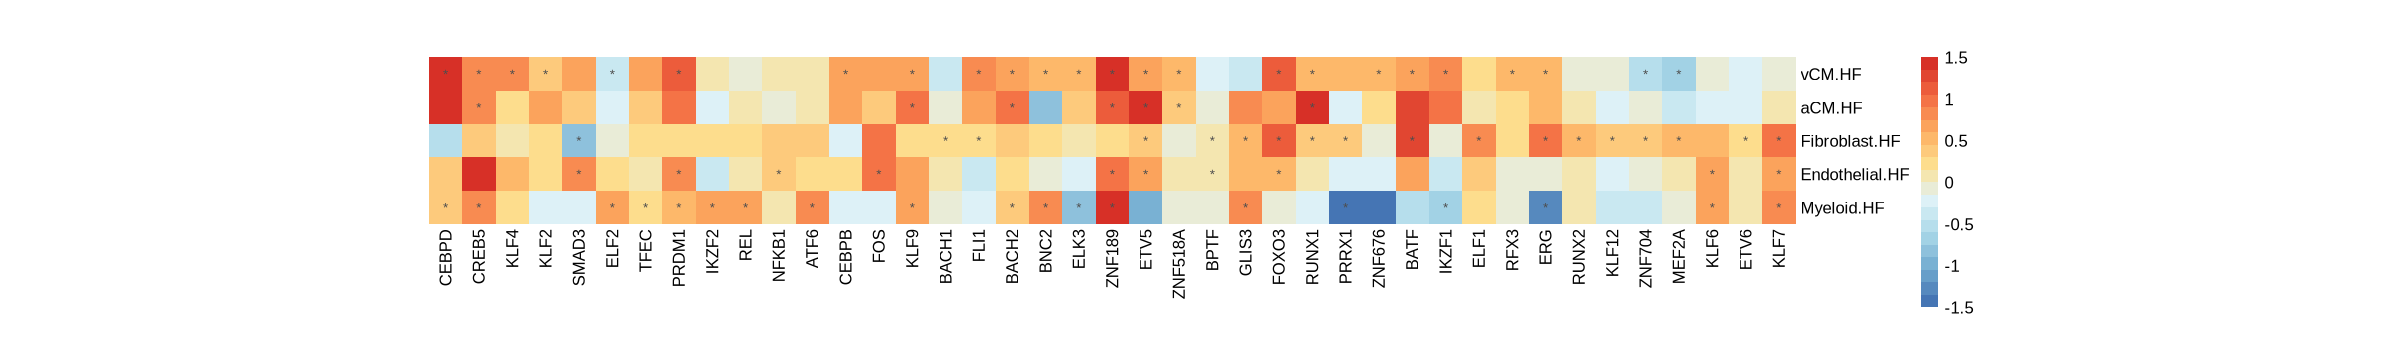

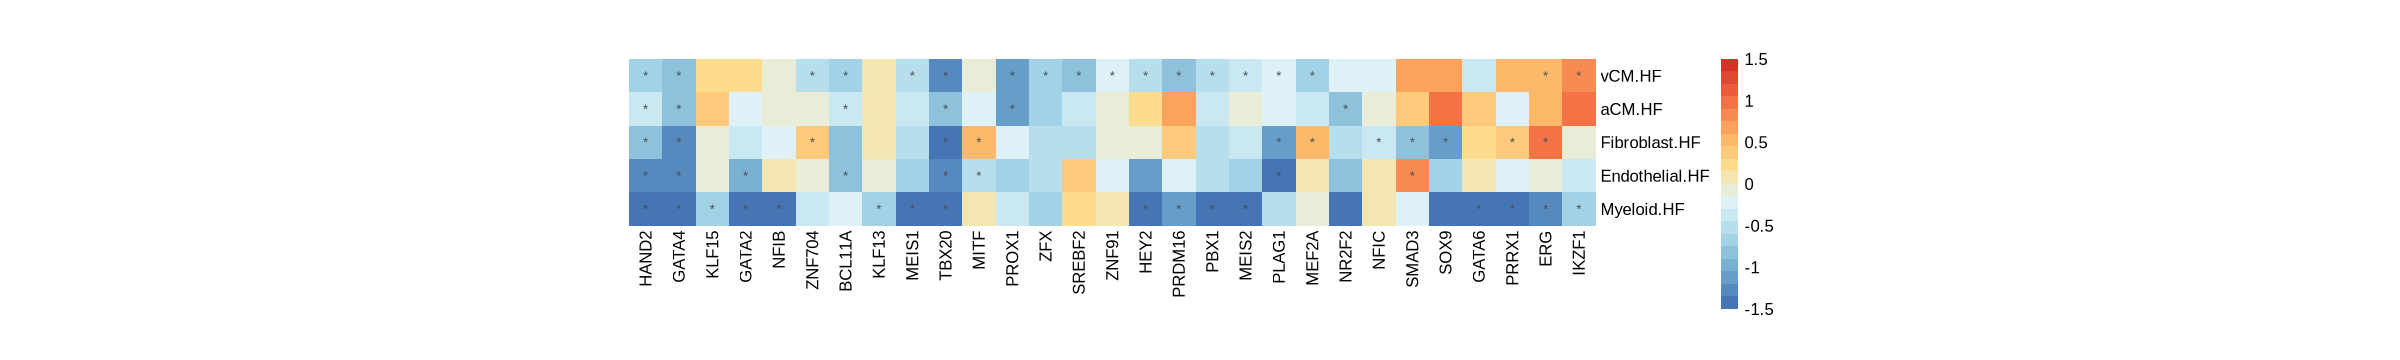

In [222]:
lmat <- do.call(rbind, tflist) %>%
mutate(value = padj) %>%
reshape2::dcast(celltype ~ gene, value.var = "value") %>%
tibble::column_to_rownames("celltype") 

lmat[,setdiff(colnames(m1), colnames(lmat))] <- 1
lmat[is.na(lmat)] <- 1
lmat <- ifelse(lmat < 0.05, "*", "")

m1 <- log2(rpkm[t1$tree_col$labels[t1$tree_col$order], paste0(rownames(rmat), ".HF")]/rpkm[t1$tree_col$labels[t1$tree_col$order], paste0(rownames(rmat), ".CONTROL")]) %>%
t %>% as.data.frame
t3 <- m1[,t1$tree_col$labels[t1$tree_col$order]] %>%
pheatmap(cluster_rows = F, cluster_cols = F, 
         display_numbers = lmat[gsub(".HF", "", rownames(m1)), t1$tree_col$labels[t1$tree_col$order]], 
         breaks = seq(-1.5,1.5,0.15),
         border_color = NA, angle_col = 90, cellwidth = 20, cellheight = 20,
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdYlBu"))(20)))

m1 <- log2(rpkm[t2$tree_col$labels[t2$tree_col$order], paste0(rownames(rmat), ".HF")]/rpkm[t2$tree_col$labels[t2$tree_col$order], paste0(rownames(rmat), ".CONTROL")]) %>%
t %>% as.data.frame
t4 <- m1[,t2$tree_col$labels[t2$tree_col$order]] %>%
pheatmap(cluster_rows = F, cluster_cols = F, 
         display_numbers = lmat[gsub(".HF", "", rownames(m1)), t2$tree_col$labels[t2$tree_col$order]], 
         breaks = seq(-1.5,1.5,0.15),
         border_color = NA, angle_col = 90, cellwidth = 20, cellheight = 20,
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdYlBu"))(20)))

### Different GRNs between aCM and vCM

[1] "BACH2" "CREB5" "KLF9"

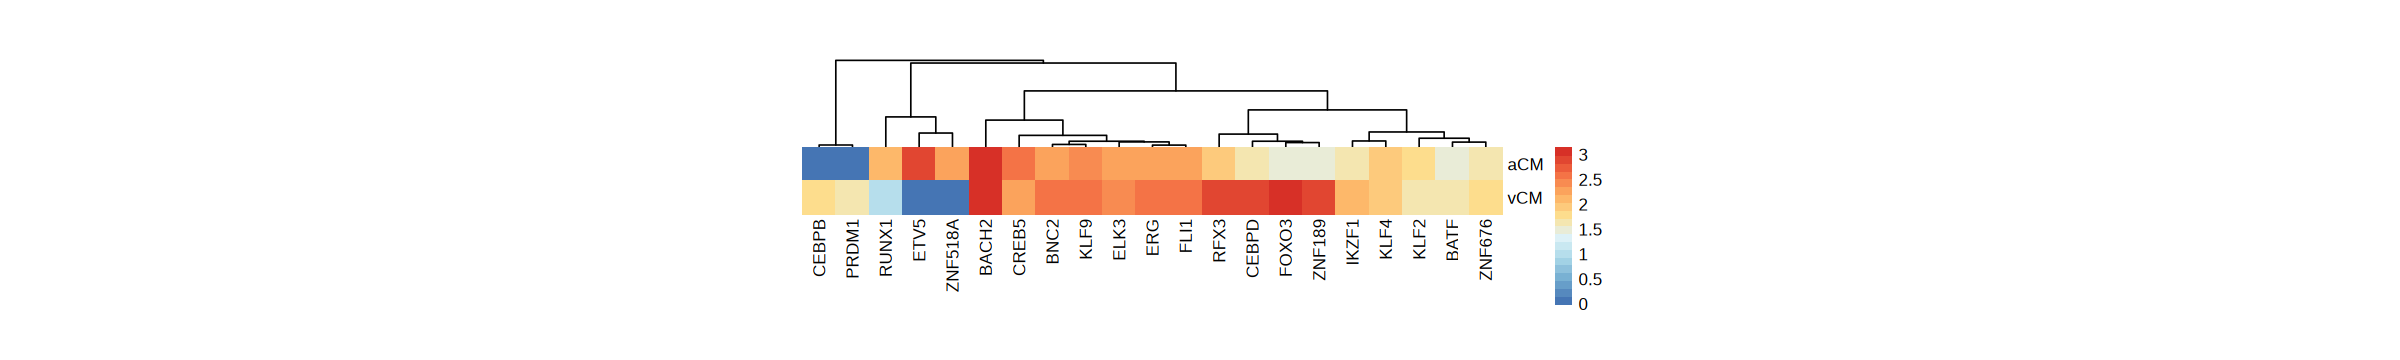

In [1143]:
vtf <- upGRN %>% filter(celltype == "vCM") %>% dplyr::select(gene) %>% unlist %>% unique
atf <- upGRN %>% filter(celltype == "aCM") %>% dplyr::select(gene) %>% unlist %>% unique
intersect(vtf, atf)# %>% length
t1 <- rmat[c("aCM", "vCM"), unique(c(vtf, atf))]  %>% 
pheatmap(cluster_rows = F, cluster_cols = T, # breaks = seq(-3,3,0.3),
         border_color = NA, angle_col = 90, cellwidth = 20, cellheight = 20,
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdYlBu"))(20)))

In [1122]:
### Calculate proportion of elements become activated
rratio <- list()
for (qtf in setdiff(atf, vtf)){
    qqpeak <- elist %>% filter(celltype == "aCM") %>% 
    filter(Consensus_name == paste0(qtf, "_+_+")) %>% dplyr::select(Region) %>% unlist %>% unique
    qchmm <- chmm[qqpeak, grep("aCM", colnames(chmm), value = T)] %>% 
    count(across(everything())) %>%
    setNames(c("CONTROL", "HF", "n"))
    acont = qchmm %>% filter(HF == "E5", CONTROL != "E5") %>% dplyr::select(n) %>% sum
    
    qchmm <- chmm[qqpeak, grep("vCM", colnames(chmm), value = T)] %>% 
    count(across(everything())) %>%
    setNames(c("CONTROL", "HF", "n"))
    vcont = qchmm %>% filter(HF == "E5", CONTROL != "E5") %>% dplyr::select(n) %>% sum
    rratio[[qtf]] <- data.frame(tf = qtf, aratio = acont / length(qqpeak), vratio = vcont / length(qqpeak), class = "aCM")
}

for (qtf in setdiff(vtf, atf)){
    qqpeak <- elist %>% filter(celltype == "vCM") %>% 
    filter(Consensus_name == paste0(qtf, "_+_+")) %>% dplyr::select(Region) %>% unlist %>% unique
    qchmm <- chmm[qqpeak, grep("aCM", colnames(chmm), value = T)] %>% 
    count(across(everything())) %>%
    setNames(c("CONTROL", "HF", "n"))
    acont = qchmm %>% filter(HF == "E5", CONTROL != "E5") %>% dplyr::select(n) %>% sum
    
    qchmm <- chmm[qqpeak, grep("vCM", colnames(chmm), value = T)] %>% 
    count(across(everything())) %>%
    setNames(c("CONTROL", "HF", "n"))
    vcont = qchmm %>% filter(HF == "E5", CONTROL != "E5") %>% dplyr::select(n) %>% sum
    rratio[[qtf]] <- data.frame(tf = qtf, aratio = acont / length(qqpeak), vratio = vcont / length(qqpeak), class = "vCM")
}

for (qtf in intersect(vtf, atf)){
    qqpeak <- elist %>% filter(celltype %in% c("vCM", "aCM")) %>% 
    filter(Consensus_name == paste0(qtf, "_+_+")) %>% dplyr::select(Region) %>% unlist %>% unique
    qchmm <- chmm[qqpeak, grep("aCM", colnames(chmm), value = T)] %>% 
    count(across(everything())) %>%
    setNames(c("CONTROL", "HF", "n"))
    acont = qchmm %>% filter(HF == "E5", CONTROL != "E5") %>% dplyr::select(n) %>% sum
    
    qchmm <- chmm[qqpeak, grep("vCM", colnames(chmm), value = T)] %>% 
    count(across(everything())) %>%
    setNames(c("CONTROL", "HF", "n"))
    vcont = qchmm %>% filter(HF == "E5", CONTROL != "E5") %>% dplyr::select(n) %>% sum
    rratio[[qtf]] <- data.frame(tf = qtf, aratio = acont / length(qqpeak), vratio = vcont / length(qqpeak), class = "shared")
}

do.call(rbind, rratio) %>%
head

,tf,aratio,vratio,class
,<chr>,<dbl>,<dbl>,<chr>
ETV5,ETV5,0.15517241,0.06896552,aCM
RUNX1,RUNX1,0.16666667,0.00000000,aCM
ZNF518A,ZNF518A,0.10000000,0.00000000,aCM
BATF,BATF,0.00000000,0.42857143,vCM
BNC2,BNC2,0.09210526,0.21052632,vCM
CEBPB,CEBPB,0.00000000,0.10000000,vCM


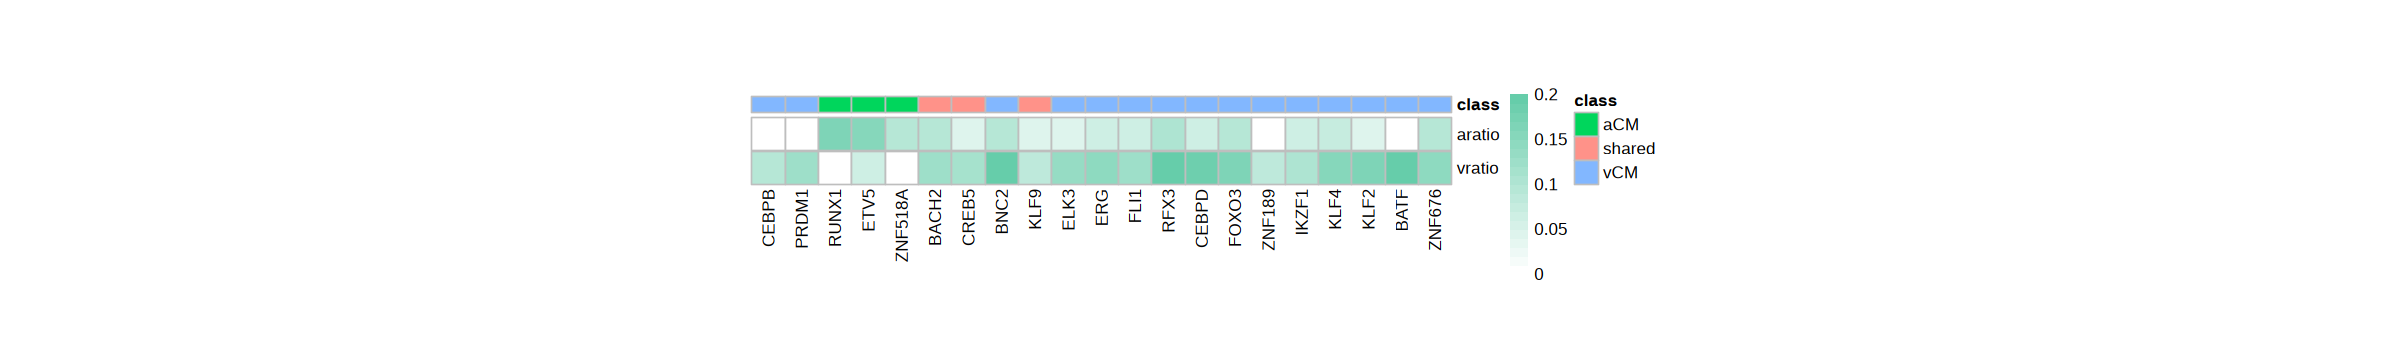

In [1147]:
options(repr.plot.width = 20, repr.plot.height = 3)

tmp <- do.call(rbind, rratio)
canno <- tmp %>% dplyr::select(class) 
tmp <- tmp %>% dplyr::select(aratio, vratio) %>% t 
tmp[tmp > 0.2] <- 0.2
t2 <- tmp[, t1$tree_col$labels[t1$tree_col$order]] %>%
pheatmap(cluster_rows = F, cluster_cols = F, annotation_col = canno,
         border_color = "gray", angle_col = 90, cellwidth = 20, cellheight = 20,
         color = colorRampPalette(colors = c("white", "#66cdaa"))(20)) 

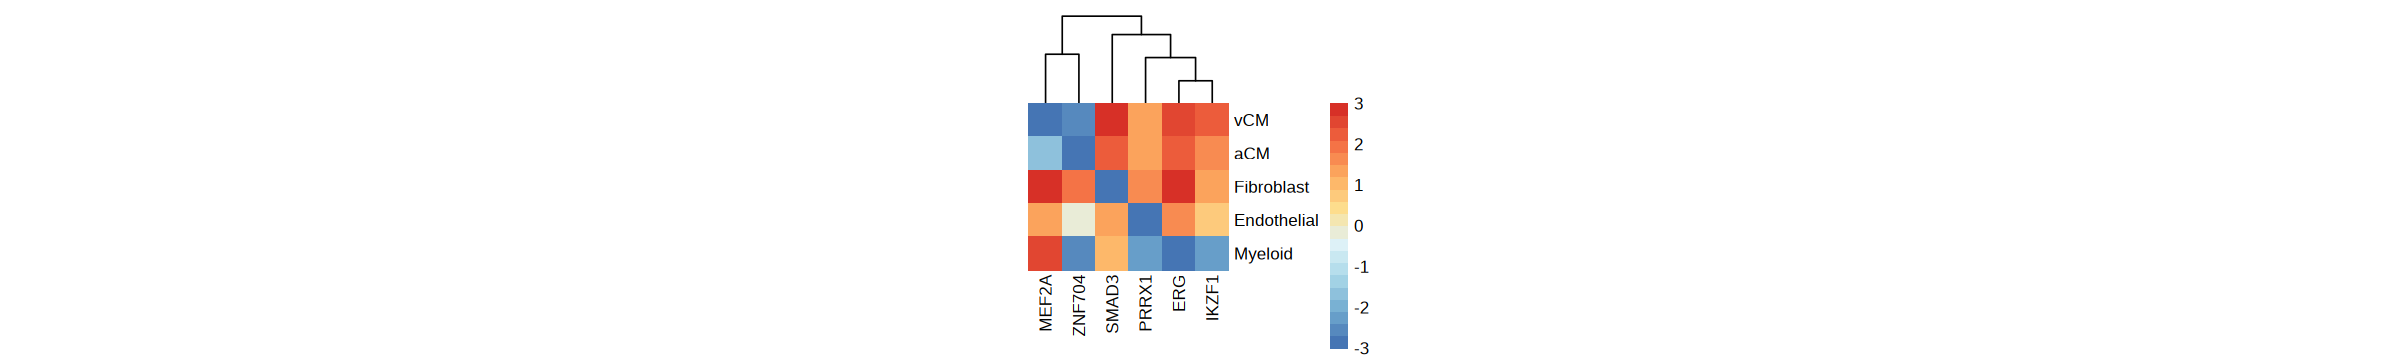

In [1130]:
### dual factor
dual <- intersect(unique(upGRN$gene), unique(downGRN$gene))

options(repr.plot.width = 20, repr.plot.height = 3)
t1 <- rmat[,dual] %>% 
pheatmap(cluster_rows = F, cluster_cols = T, breaks = seq(-3,3,0.3),
         border_color = NA, angle_col = 90, cellwidth = 20, cellheight = 20,
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdYlBu"))(20)))

In [1233]:
### example: MEF2A
### target regions
options(repr.plot.width = 4, repr.plot.height = 6)

qregion <- elist %>% filter(celltype == "vCM", Consensus_name == "MEF2A_+_+") %>% 
dplyr::select(Region) %>% unlist %>% unique
t1 <- chmm[qregion, grep(paste0(c("vCM","Fibroblast"), collapse = "|"), colnames(chmm), value = T)] %>%
tibble::rownames_to_column("bin") %>% 
reshape2::melt(id.vars = 'bin') %>% 
dplyr::select(variable, value) %>%
table %>% as.data.frame %>%
ggplot(aes(x = variable, y = Freq, fill = value)) +
geom_col(position = "fill", color = "white") + 
theme_Publication() + ggtitle("MEF2A targeting region in vCM") +
scale_fill_manual(values = cols)

qregion <- elist %>% filter(celltype == "Fibroblast", Consensus_name == "MEF2A_+_+") %>% 
dplyr::select(Region) %>% unlist %>% unique
t2 <- chmm[qregion, grep(paste0(c("vCM","Fibroblast"), collapse = "|"), colnames(chmm), value = T)] %>%
tibble::rownames_to_column("bin") %>% 
reshape2::melt(id.vars = 'bin') %>% 
dplyr::select(variable, value) %>%
table %>% as.data.frame %>%
ggplot(aes(x = variable, y = Freq, fill = value)) +
geom_col(position = "fill", color = "white") + 
theme_Publication() + ggtitle("MEF2A targeting region in Fibroblast") +
scale_fill_manual(values = cols)

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


In [1235]:
### target genes
qgene <- elist %>% filter(celltype == "vCM", Consensus_name == "MEF2A_+_+") %>% 
dplyr::select(Gene) %>% unlist %>% unique

options(repr.plot.width = 4, repr.plot.height = 4)
t1 <- rpkm[qgene, sort(grep(paste0(c("vCM","Fibroblast"), collapse = "|"), colnames(rpkm), value = T))] %>%
tibble::rownames_to_column("gene") %>%
reshape2::melt(id.vars = "gene") %>%
ggplot(aes(x = variable, y = value, fill = variable)) + 
geom_boxplot(width = 0.4, coef = 2, outlier.shape = NA, alpha = 0.8) +
scale_y_log10() + 
theme_Publication()

qgene <- elist %>% filter(celltype == "Fibroblast", Consensus_name == "MEF2A_+_+") %>% 
dplyr::select(Gene) %>% unlist %>% unique
t2 <- rpkm[qgene, sort(grep(paste0(c("vCM","Fibroblast"), collapse = "|"), colnames(rpkm), value = T))] %>%
tibble::rownames_to_column("gene") %>%
reshape2::melt(id.vars = "gene") %>%
ggplot(aes(x = variable, y = value, fill = variable)) + 
geom_boxplot(width = 0.4, coef = 2, outlier.shape = NA, alpha = 0.8) +
scale_y_log10() + 
theme_Publication()

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


## Shared TF: different funcions

In [1163]:
### While TF are the same, whether tageting region / genes are the same?
### example in vCM / aCM
qtf <- "BACH2"
qpeak1 <- elist %>% filter(celltype == "vCM") %>% 
filter(Consensus_name %in% paste0(qtf, "_+_+")) %>% dplyr::select(Region) %>% unlist %>% unique

qpeak2 <- elist %>% filter(celltype == "aCM") %>% 
filter(Consensus_name %in% paste0(qtf, "_+_+")) %>% dplyr::select(Region) %>% unlist %>% unique

length(qpeak1); length(qpeak2)
intersect(qpeak1, qpeak2) %>% length

qgene1 <- elist %>% filter(celltype == "vCM") %>% 
filter(Consensus_name %in% paste0(qtf, "_+_+")) %>% dplyr::select(Gene) %>% unlist %>% unique

qgene2 <- elist %>% filter(celltype == "aCM") %>% 
filter(Consensus_name %in% paste0(qtf, "_+_+")) %>% dplyr::select(Gene) %>% unlist %>% unique

length(qgene1); length(qgene2)
intersect(qgene1, qgene2) %>% length

[1] 171

[1] 371

[1] 44

[1] 84

[1] 195

[1] 36

In [1088]:
suppressPackageStartupMessages(library(ggVennDiagram))

qpeak <- qgene <- list()
for (ct in list.files("GRN/scenicplus/")){
    if (ct != "Lymphoid"){
        qpeak[[ct]] <- read.csv(paste0("GRN/scenicplus/", ct, "/edges_R2G.csv")) %>% 
        filter(is_extended == "False") %>% 
        filter(Consensus_name %in% paste0(qtf, "_+_+")) %>% dplyr::select(Region) %>% unlist %>% unique

        qgene[[ct]] <- read.csv(paste0("GRN/scenicplus/", ct, "/edges_R2G.csv")) %>% 
        filter(is_extended == "False") %>% 
        filter(Consensus_name %in% paste0(qtf, "_+_+")) %>% dplyr::select(Gene) %>% unlist %>% unique
    }
}

t1 <- ggVennDiagram(qpeak, force_upset = T) #+ NoLegend()
t2 <- ggVennDiagram(qgene, force_upset = T) #+ NoLegend()

ggsave(t1, filename = paste0("plot/FIG_SCENIC_", qtf, "_target_region.pdf"), dpi = 300, height = 6, width = 6)
ggsave(t2, filename = paste0("plot/FIG_SCENIC_", qtf, "_target_gene.pdf"), dpi = 300, height = 6, width = 6)

### Target region chromHMM?

In [1188]:
### vCM peaks
qqpeak <- setdiff(qpeak1, qpeak2)

qchmm <- chmm[qqpeak, grep(paste0(c("vCM"),collapse = "|"), colnames(chmm))] %>% 
count(across(everything())) %>% 
setNames(c("CONTROL", "HF", "n"))
vcont = qchmm %>% filter(HF == "E5", CONTROL != "E5") %>% dplyr::select(n) %>% sum
vcont1 = vcont/length(qqpeak)

vcont = qchmm %>% filter(HF == "E3", CONTROL != "E3") %>% dplyr::select(n) %>% sum
vcont2 = vcont/length(qqpeak)

qchmm <- chmm[qqpeak, grep(paste0(c("aCM"),collapse = "|"), colnames(chmm))] %>% 
count(across(everything())) %>% 
setNames(c("CONTROL", "HF", "n"))
vcont = qchmm %>% filter(HF == "E5", CONTROL != "E5") %>% dplyr::select(n) %>% sum
vcont3 = vcont/length(qqpeak)

vcont = qchmm %>% filter(HF == "E3", CONTROL != "E3") %>% dplyr::select(n) %>% sum
vcont4 = vcont/length(qqpeak)

In [1189]:
### aCM peaks
qqpeak <- setdiff(qpeak2, qpeak1)
qchmm <- chmm[qqpeak, grep(paste0(c("vCM"),collapse = "|"), colnames(chmm))] %>% 
count(across(everything())) %>% 
setNames(c("CONTROL", "HF", "n"))
acont = qchmm %>% filter(HF == "E5", CONTROL != "E5") %>% dplyr::select(n) %>% sum
acont1 = acont/length(qqpeak)

acont = qchmm %>% filter(HF == "E3", CONTROL != "E3") %>% dplyr::select(n) %>% sum
acont2 = acont/length(qqpeak)

qchmm <- chmm[qqpeak, grep(paste0(c("aCM"),collapse = "|"), colnames(chmm))] %>% 
count(across(everything())) %>% 
setNames(c("CONTROL", "HF", "n"))
acont = qchmm %>% filter(HF == "E5", CONTROL != "E5") %>% dplyr::select(n) %>% sum
acont3 = acont/length(qqpeak)

acont = qchmm %>% filter(HF == "E3", CONTROL != "E3") %>% dplyr::select(n) %>% sum
acont4 = acont/length(qqpeak)

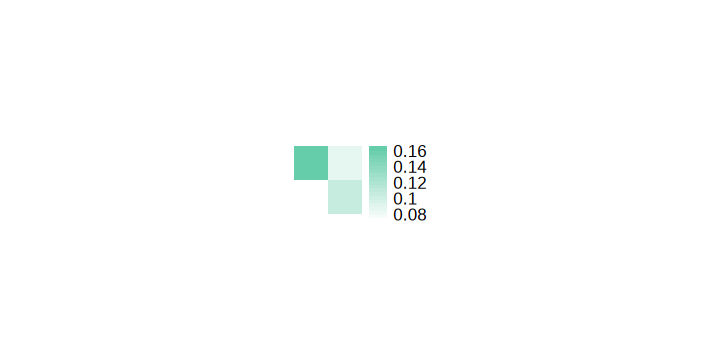

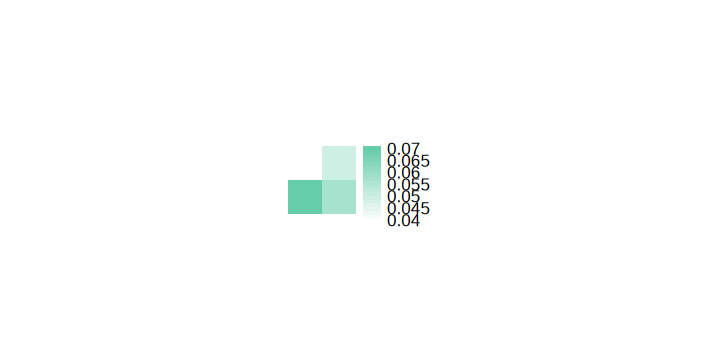

In [1192]:
options(repr.plot.width = 6, repr.plot.height = 3)
mtx <- matrix(c(vcont1, vcont3, acont1, acont3), ncol = 2) ### col: vCM specific peaks, aCM specific peaks
t1 <- mtx %>%
pheatmap(cluster_rows = F, cluster_cols = F, border_color = NA, angle_col = 90, cellwidth = 20, cellheight = 20,
        color = colorRampPalette(colors = c("white", "#66cdaa"))(20))

mtx <- matrix(c(vcont2, vcont4, acont2, acont4), ncol = 2) ### col: vCM specific peaks, aCM specific peaks
t2 <- mtx %>%
pheatmap(cluster_rows = F, cluster_cols = F, border_color = NA, angle_col = 90, cellwidth = 20, cellheight = 20,
        color = colorRampPalette(colors = c("white", "#66cdaa"))(20))

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


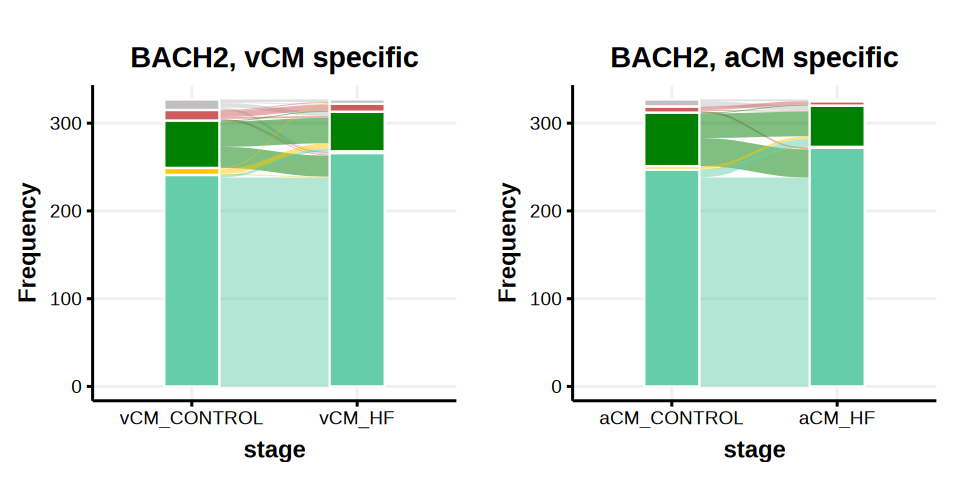

In [1175]:
qqpeak <- setdiff(qpeak2, qpeak1)

t1 <- chmm[qqpeak, grep(paste0(c("vCM"),collapse = "|"), colnames(chmm))] %>% 
count(across(everything())) %>%
mutate(id = 1:nrow(.)) %>%
tidyr::pivot_longer(cols = starts_with("vCM"), names_to = "stage", values_to = "state") %>%
mutate(state = factor(state, levels = c("E2", "E1", "E3", "E4", "E5"))) %>%
ggplot(aes(x = stage, stratum = state, alluvium = id, y = n, fill = state)) +
geom_flow() + ylab("Frequency") + 
geom_stratum(color = "white") +
NoLegend() + theme_Publication() + ggtitle(paste0(qtf, ", vCM specific")) + 
scale_fill_manual(values = cols) + NoLegend()

t2 <- chmm[qqpeak, grep(paste0(c("aCM"),collapse = "|"), colnames(chmm))] %>% 
count(across(everything())) %>%
mutate(id = 1:nrow(.)) %>%
tidyr::pivot_longer(cols = starts_with("aCM"), names_to = "stage", values_to = "state") %>%
mutate(state = factor(state, levels = c("E2", "E1", "E3", "E4", "E5"))) %>%
ggplot(aes(x = stage, stratum = state, alluvium = id, y = n, fill = state)) +
geom_flow() + ylab("Frequency") + 
geom_stratum(color = "white") +
NoLegend() + theme_Publication() + ggtitle(paste0(qtf, ", aCM specific")) + 
scale_fill_manual(values = cols) + NoLegend()

options(repr.plot.width = 8, repr.plot.height = 4)
fig1 <- cowplot::plot_grid(t1, t2)

fig1

## vCM HF GRN

In [901]:
ct <- "vCM"
elist <- read.csv(paste0("GRN/scenicplus/", ct, "/edges_R2G.csv")) %>% filter(is_extended == "False")
rpeak <- read.table(paste0("../reference/FNIH_peaks/unified_peaks/", ct, "_UnifiedFiltVariable.bed")) %>%
mutate(range = paste0(V1, ":", V2, "-", V3))
setdiff(elist$Region, rpeak$range) %>% length
intersect(elist$Region, rpeak$range) %>% length
### Not all peaks are shared!

elist <- elist %>% filter(Region %in% rpeak$range)

[1] 1222

[1] 3614

In [902]:
### Target gene GO
qgrn <- upGRN %>%
filter(celltype == ct) %>%
dplyr::select(gene) %>% unlist %>% unique

clist <- list()
for (f in qgrn){ #unique(diffpair1$celltype.x)
    qgene <- elist %>% filter(Consensus_name %in% paste0(f, "_+_+")) 
    qtable <- enrichGO(gene = unique(qgene$Gene),
                OrgDb = org.Hs.eg.db,
                keyType = 'SYMBOL',
                ont = "BP", # biological process
                pAdjustMethod = "BH", 
                pvalueCutoff = 0.05, 
                qvalueCutoff = 0.05, 
                readable = TRUE)
    clist[[f]] <- qtable@result %>% mutate(tf = f)
}

do.call(rbind, clist) %>% 
filter(p.adjust < 0.05) %>%
dplyr::select(tf) %>% table

tf
BACH2  BNC2 CEBPD CREB5  ELK3   ERG  FLI1 IKZF1  KLF2  KLF4  KLF9 PRDM1 
    8    23     4    49    20    57   154   142    56    77     4    66 

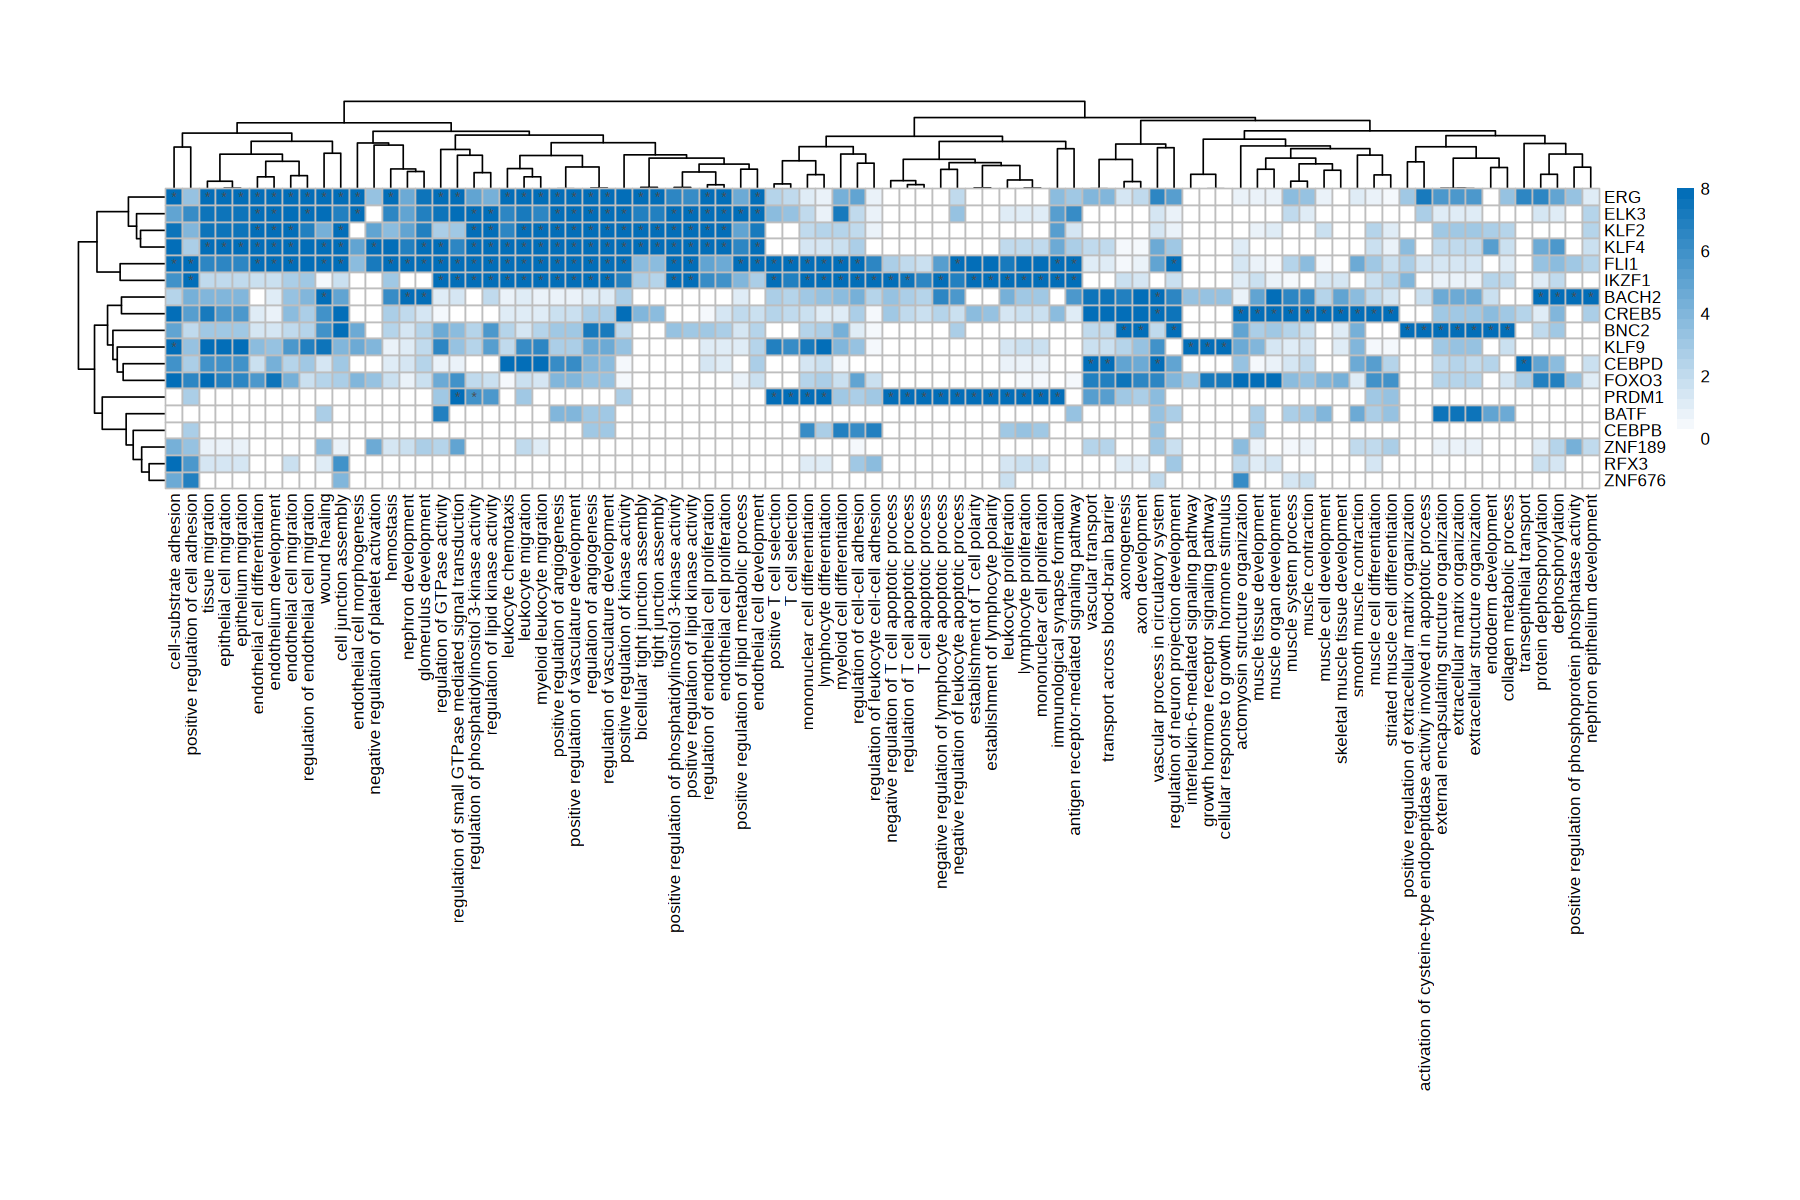

In [903]:
qterm1 <- do.call(rbind, clist) %>% 
filter(p.adjust < 0.05) %>% 
group_by(tf) %>%
slice_max(order_by = -log10(pvalue), n = 10) %>% ungroup %>%
dplyr::select(Description) %>% unlist %>% unique %>% as.character

tmp <- do.call(rbind, clist) %>% 
reshape2::dcast(Description ~ tf, value.var = "pvalue", fun.aggregate = mean) %>%
tibble::column_to_rownames("Description")
tmp[is.na(tmp)] <- 1
tmp <- -log2(tmp)

ttp <- tmp[c(qterm1), ]
ttp[ttp > 8] <- 8

lmat <- do.call(rbind, clist) %>% 
mutate(value = p.adjust) %>%
reshape2::dcast(Description ~ tf, value.var = "value", fun.aggregate = mean) %>%
tibble::column_to_rownames("Description") 

lmat[is.na(lmat)] <- 1
lmat <- ifelse(lmat < 0.05, "*", "")

options(repr.plot.width = 15, repr.plot.height = 10)
t1 <- ttp %>% t %>%
pheatmap(cluster_cols = T, cluster_rows = T, border_color = "gray", angle_col = 90, cellwidth = 10, cellheight = 10,
         display_numbers = t(lmat[rownames(ttp), colnames(ttp)]), # breaks = seq(-4,4,0.4),
         color = colorRampPalette(c("white", "#036EB8"))(25))
tforder <- t1$tree_row$label[t1$tree_row$order]

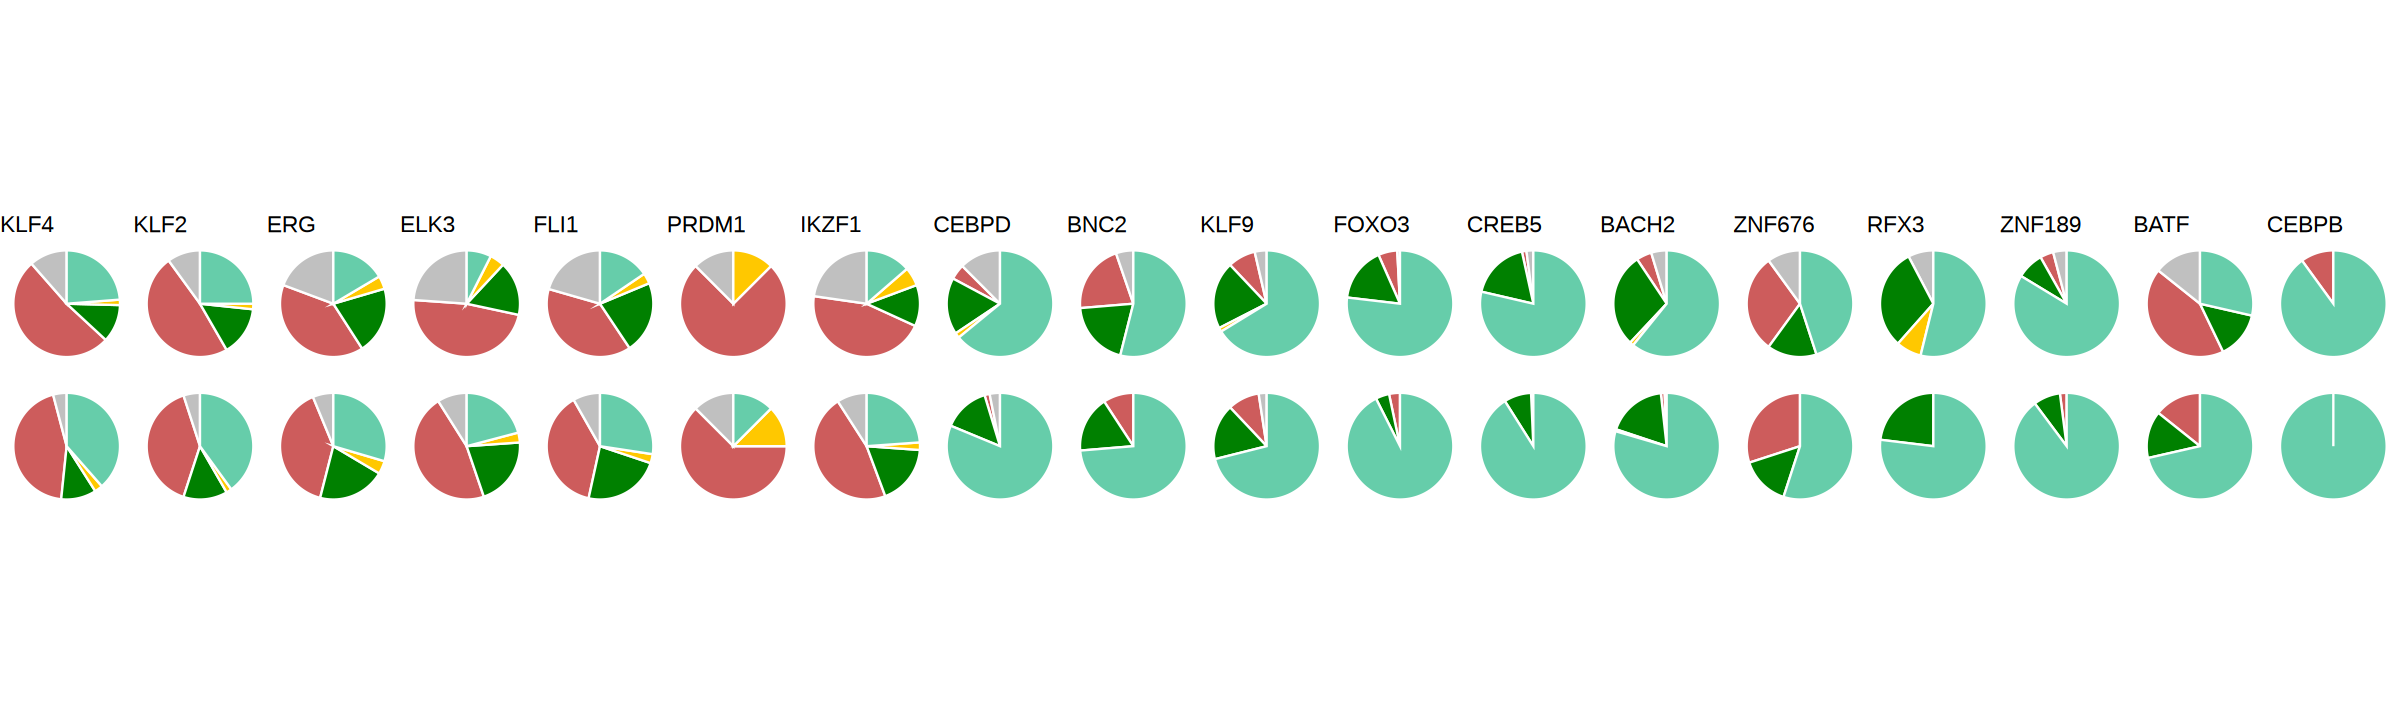

In [940]:
tforder <- c('KLF4','KLF2','ERG','ELK3','FLI1','PRDM1','IKZF1','CEBPD','BNC2','KLF9','FOXO3',
             'CREB5','BACH2','ZNF676','RFX3','ZNF189','BATF','CEBPB')
plist <- list()
for (qtf in tforder){
    qqpeak <- elist %>% 
    filter(Consensus_name == paste0(qtf, "_+_+")) %>% 
    dplyr::select(Region) %>% unlist %>% unique
    tmp <- chmm[qqpeak, grep(paste0(ct, collapse = "|"), colnames(chmm))] %>% 
    apply(MARGIN = 2, function(x) as.data.frame(table(x)))
          
    plist[[qtf]] <- do.call(rbind, tmp) %>%
    mutate(class = gsub("^([^.]+)\\.([^.]+)$", "\\1", rownames(.))) %>%
          mutate(x = factor(x, levels = c("E2","E1", "E3" ,"E4", "E5"))) %>%
    ggplot(aes(x = "", y = Freq, fill = x)) +
    geom_bar(width = 1, stat = "identity", color = "white") +
    coord_polar(theta = "y") + 
    theme_void() + facet_grid(class ~ .) +
    theme(strip.text = element_blank()) + ggtitle(qtf) + 
    scale_fill_manual(values = cols) + NoLegend()
}

options(repr.plot.width = 20, repr.plot.height = 6)
fig1 <- cowplot::plot_grid(plotlist = plist, ncol = length(plist))
fig1
ggsave(fig1, filename = "plot/FIG_vCM_upGRN_target_region_chromhmm.pdf", 
       dpi = 300, height = 5, width = 20)

In [1248]:
qtf <- "FOS"
olist <- list()
for(ct in unique(elist$celltype)){
    qgene <- elist %>% filter(celltype == ct) %>% 
    filter(Consensus_name %in% paste0(qtf, "_+_+")) %>% dplyr::select(Gene) %>% unlist
    qtable <- enrichGO(gene = qgene,
                OrgDb = org.Hs.eg.db,
                keyType = 'SYMBOL',
                ont = "BP", 
                pAdjustMethod = "BH", 
                pvalueCutoff = 0.05, 
                qvalueCutoff = 0.05, 
                readable = TRUE)
    if (nrow(qtable@result) > 0){
        olist[[ct]] <- qtable@result %>% mutate(celltype = ct)
    }
}  

olist <- do.call(rbind, olist)

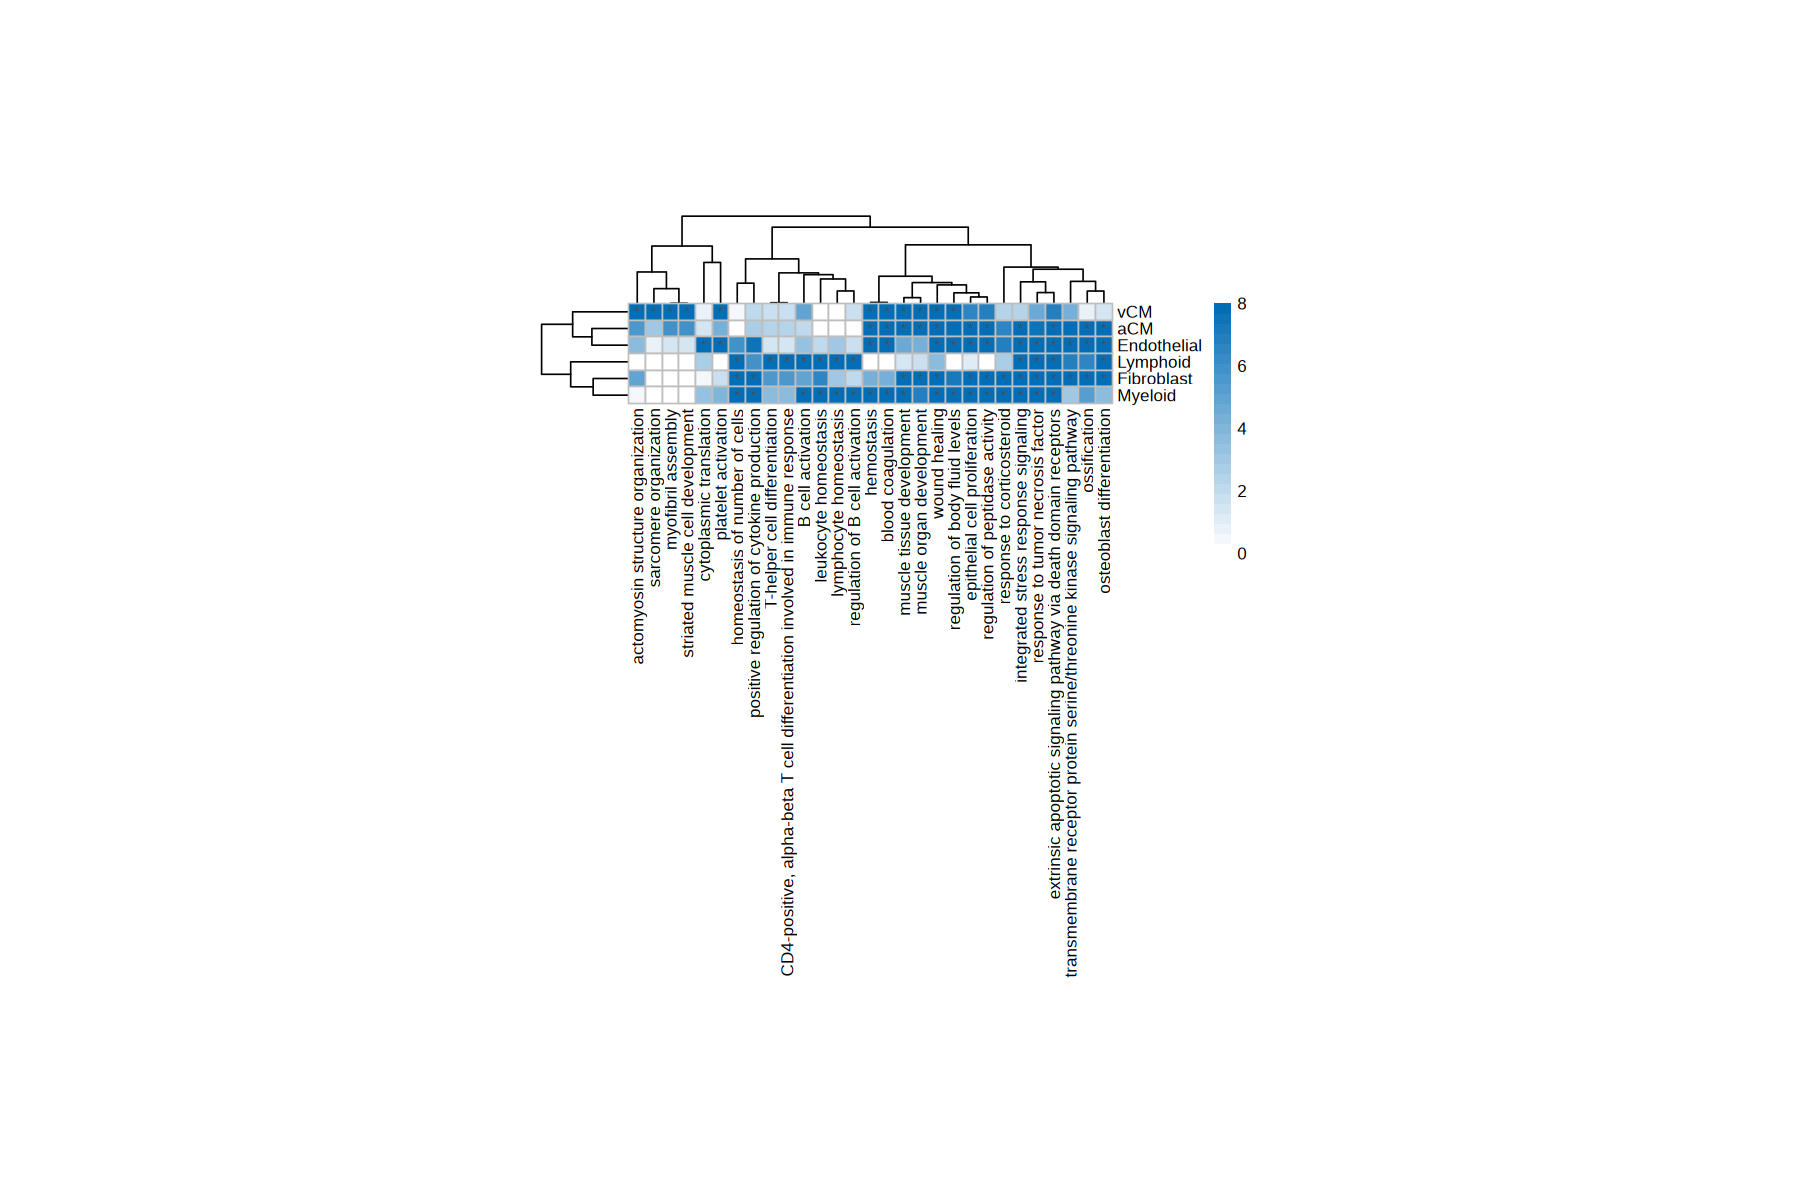

In [1257]:
qterm1 <- olist %>% 
filter(p.adjust < 0.05) %>% 
group_by(celltype) %>%
slice_max(order_by = -log10(pvalue), n = 5) %>% ungroup %>%
dplyr::select(Description) %>% unlist %>% unique %>% as.character

tmp <- olist %>% 
reshape2::dcast(Description ~ celltype, value.var = "pvalue", fun.aggregate = mean) %>%
tibble::column_to_rownames("Description")
tmp[is.na(tmp)] <- 1
tmp <- -log2(tmp)

ttp <- tmp[c(qterm1), ]
ttp[ttp > 8] <- 8

lmat <- olist %>% 
mutate(value = p.adjust) %>%
reshape2::dcast(Description ~ celltype, value.var = "value", fun.aggregate = mean) %>%
tibble::column_to_rownames("Description") 

lmat[is.na(lmat)] <- 1
lmat <- ifelse(lmat < 0.05, "*", "")

options(repr.plot.width = 15, repr.plot.height = 10)
t1 <- ttp %>% t %>%
pheatmap(cluster_cols = T, cluster_rows = T, border_color = "gray", angle_col = 90, cellwidth = 10, cellheight = 10,
         display_numbers = t(lmat[rownames(ttp), colnames(ttp)]), # breaks = seq(-4,4,0.4),
         color = colorRampPalette(c("white", "#036EB8"))(25))